# Import

In [1]:
import numpy as np
import pandas as pd
import tqdm
import argparse
import os
import shutil
import pickle
from ai_clinician.modeling.models.komorowski_model import *
from ai_clinician.modeling.models.common import *
from ai_clinician.modeling.columns import C_OUTCOME
from ai_clinician.preprocessing.utils import load_csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tqdm.tqdm.pandas()

In [2]:
def create_args():
    parser = argparse.ArgumentParser(description=(
        'Evaluates an AI Clinician model on the MIMIC-IV test set.'
    ))
    parser.add_argument('data', type=str,
                        help='Model data directory (should contain train and test directories)')
    parser.add_argument('model', type=str,
                        help='Path to pickle file containing the model')
    parser.add_argument('--out', dest='out_path', type=str, default=None,
                        help='Path to pickle file at which to write out results (optional)')
    parser.add_argument('--gamma', dest='gamma', type=float, default=0.99,
                        help='Decay for reward values (default 0.99)')
    parser.add_argument('--soften-factor', dest='soften_factor', type=float, default=0.05,
                        help='Amount by which to soften factors (random actions will be chosen this proportion of the time)')
    parser.add_argument('--num-iter-ql', dest='num_iter_ql', type=int, default=6,
                        help='Number of bootstrappings to use for TD learning (physician policy)')
    parser.add_argument('--num-iter-wis', dest='num_iter_wis', type=int, default=1000,
                        help='Number of bootstrappings to use for WIS estimation (AI policy)')
    
    # Simulate command-line arguments
    simulated_input = [
        '/home/lkapral/RRT_mimic_iv/data/model',     # Replace with your actual data directory
        '/home/lkapral/RRT_mimic_iv/data/model/models_penal/0.22/model_params_40/top5/top5_model_2.pkl',    # Replace with your actual model path
        #'/home/lkapral/RRT_mimic_iv/data/model/models/model_params/best_model.pkl',
        '--gamma', '0.99',
        '--soften-factor', '0.01',
        '--num-iter-ql', '6',
        '--num-iter-wis', '500'
    ]
    
    return parser.parse_args(simulated_input)

# Use the args
args = create_args()
output_dir = '/home/lkapral/RRT_mimic_iv/data/model'
data_dir = args.data
model = AIClinicianModel.load(args.model)
assert model.metadata is not None, "Model missing metadata needed to generate actions"


 

Loaded_feature_weights [0.3943926  0.27756421 0.24343556 0.23991552 0.21412183 0.18868424
 0.1835645  0.18020105 0.17104588 0.1679103  0.16144925 0.15938839
 0.15371076 0.1529229  0.15073967 0.1478161  0.1438637  0.1434054
 0.1417021  0.14009531 0.11779231 0.11505856 0.11428096 0.11317841
 0.11120712 0.11085235 0.1085031  0.10663935 0.10595175 0.10565174
 0.10279287 0.10241132 0.10177746 0.10109605 0.09985348 0.09779006
 0.09721884 0.09706016 0.09613519 0.09512068 1.        ]


In [3]:
fixed_num_features = 40

feature_importance = pd.read_csv('/home/lkapral/RRT_mimic_iv/data/model/combined_feature_importances.csv')

weights = feature_importance.head(fixed_num_features)['Combined_Average'].values
feature_weights = weights / np.linalg.norm(weights)

In [4]:
reduced_features = feature_importance.head(fixed_num_features)['Feature'].tolist()

In [5]:
MIMICraw = load_csv(os.path.join(data_dir, "test", "MIMICraw.csv"))
#MIMICzs = load_csv(os.path.join(data_dir, "test", "MIMICzs.csv"))
MIMICzs = pd.read_csv(os.path.join(data_dir, "test", "MIMICzs.csv"))
metadata = load_csv(os.path.join(data_dir, "test", "metadata.csv"))
unique_icu_stays = metadata[C_ICUSTAYID].unique()

# Create actions based on RRT
print("Create actions")

# Define RRT-related columns
rrt_cols = [
    'Ultrafiltrate_Output',
    'Blood_Flow',
    'Hourly_Patient_Fluid_Removal',
    'Dialysate_Rate',
    'Hemodialysis_Output',  # Ensure the column name matches your DataFrame
    'Citrate',
    'Prefilter_Replacement_Rate',
    'Postfilter_Replacement_Rate'
]

# Create 'action' column
rrt_actions = (~MIMICraw[rrt_cols].isna() & (MIMICraw[rrt_cols] != 0)).any(axis=1)
MIMICraw['action'] = rrt_actions.astype(int)
# Actions array


np.seterr(divide='ignore', invalid='ignore')



Create actions


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
len(metadata['icustayid'].unique())

16283

In [7]:
model.metadata

{'actions': {'n_action_bins': 2,
  'action_bins': array([0. , 0.5, 1. ]),
  'action_medians': array([0, 1])},
 'split': {'train_ids': array([36985741, 31150594, 31642374, ..., 37790429, 39409631, 32468504]),
  'val_ids': array([35730908, 38113970, 31173295, ..., 39227723, 35718415, 33523977])},
 'eval_params': {'num_iter_ql': 6, 'num_iter_wis': 700},
 'wis_score': 80.9727863599537,
 'rank': 3,
 'model_num': 508}

In [8]:
MIMICraw['RRT'] = MIMICraw['action']
MIMICzs['RRT'] = MIMICraw['action']

# MIMICraw['icustayid'] = metadata['icustayid']

# MIMICraw['action'] = MIMICraw.groupby('icustayid')['action'].transform(
#     lambda x: x.ne(x.shift().fillna(x)).astype(int)
# )
# MIMICraw.drop(columns=['icustayid'], inplace=True)

In [9]:
actions_RRT = MIMICraw['action'].values

In [10]:
n_cluster_states = model.n_cluster_states

# Update the number of actions to 2 (binary actions)
n_actions = 2
model.n_actions = n_actions  # Update model's n_actions

# Define action_medians and action_bins for binary actions
action_medians = np.array([0, 1])
action_bins = np.array([0, 0.5, 1])

# Update model's action_bins and action_medians
model.metadata['actions']['action_bins'] = action_bins
model.metadata['actions']['action_medians'] = action_medians


In [11]:
MIMICzs = MIMICzs[reduced_features+ ['RRT']]
MIMICraw = MIMICraw[reduced_features + ['RRT']]
feature_weights = np.append(feature_weights,1)

In [12]:
cols = ['output_step', 'Creatinine', 'SOFA', 'cumulated_balance',
       'Platelets_count', 'BUN', 'Calcium', 'Chloride', 'Anion_Gap',
       'output_total', 'input_total', 'WBC_count', 'age', 'Phosphorous',
       'RASS', 'Temp_C', 'Total_bili', 'O2flow', 'Sodium', 'max_dose_vaso',
       'Weight_kg', 'GCS', 'PTT', 'RBC_count', 'RR', 'PT', 'PAWmean',
       'Ionised_Ca', 'SpO2', 'Ht', 'Hb', 'SGOT', 'extubated', 'LDH', 'FiO2_1',
       'HCO3', 'SGPT', 'Potassium', 'MinuteVentil', 'Shock_Index',
       'Arterial_pH', 'MeanBP', 'Glucose', 'INR', 'HR', 'input_step',
       'TidalVolume', 'PaO2_FiO2', 'Albumin', 'SysBP', 'paO2', 'PAWpeak',
       'PAWplateau', 'DiaBP', 'Fibrinogen', 'Arterial_BE', 'paCO2',
       'Magnesium', 'Arterial_lactate', 'CVP', 'PEEP', 'Height_cm', 'CK_MB',
       'mechvent', 'ETCO2', 'Troponin', 'Absolute_Neutrophil_Count', 'SaO2',
       'SIRS', 'Triglyceride', 'RRT']

# Policy Evaluation

In [13]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

In [14]:
blocs = metadata[C_BLOC].values
stay_ids = metadata[C_ICUSTAYID].values
outcomes = metadata[C_OUTCOME].values  # 1 if patient died, 0 if survived

print("Evaluating on MIMIC test set...")
states = model.compute_states(MIMICzs.values)

records = build_complete_record_sequences(
    metadata,
    states,
    actions_RRT,
    model.absorbing_states,
    model.rewards
)

# Evaluate the physician's policy using Temporal Difference (TD) Learning
test_bootql = evaluate_physician_policy_td(
    records,
    model.physician_policy,
    args.gamma,
    args.num_iter_ql,
    model.n_cluster_states
)
physpol_test, transitionr_test, R_test = compute_physician_policy(
    records,
    model.n_states,
    model.n_actions,
    model.absorbing_states,
    reward_val=model.reward_val,
    transition_threshold=model.transition_threshold,
)
# Compute probabilities for policy evaluation
phys_probs = model.compute_physician_probabilities(states=states, actions=actions_RRT)
model_probs = model.compute_probabilities(states=states, actions=actions_RRT)





Evaluating on MIMIC test set...


TD evaluation: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.93s/it]


Zeroing out 445/1004 transitions
Create reward matrix R(S, A)


In [15]:
# Evaluate the AI policy using Weighted Importance Sampling (WIS)
test_bootwis, _,  estimates = evaluate_policy_wis(
    metadata,
    phys_probs,
    model_probs,
    model.rewards,
    args.gamma,
    args.num_iter_wis,
    save_roh=True
)

# Prepare model statistics
model_stats = {}
model_stats['test_bootql_0.95'] = np.quantile(test_bootql, 0.95)   # Physicians' 95% Upper Bound
model_stats['test_bootql_mean'] = np.nanmean(test_bootql)
model_stats['test_bootql_0.99'] = np.quantile(test_bootql, 0.99)
model_stats['test_bootwis_mean'] = np.nanmean(test_bootwis)    
model_stats['test_bootwis_0.01'] = np.quantile(test_bootwis, 0.01)  
wis_95lb = np.quantile(test_bootwis, 0.05)  # AI's 95% Lower Bound
model_stats['test_bootwis_0.05'] = wis_95lb
model_stats['test_bootwis_0.95'] = np.quantile(test_bootwis, 0.95)

# Display the results with explanations
print("\nEvaluation Results:")

print("\n1. Physician's Policy Evaluation (Temporal Difference Learning):")
print(f"- Mean Value of Physician's Policy: {model_stats['test_bootql_mean']:.4f}")
print(f"- 95% Upper Bound of Physician's Policy Value: {model_stats['test_bootql_0.95']:.4f}")
print(f"- 99% Upper Bound of Physician's Policy Value: {model_stats['test_bootql_0.99']:.4f}")

print("\n2. AI Policy Evaluation (Weighted Importance Sampling):")
print(f"- Mean Value of AI Policy: {model_stats['test_bootwis_mean']:.4f}")
print(f"- 5% Lower Bound of AI Policy Value: {model_stats['test_bootwis_0.05']:.4f}")
print(f"- 1% Lower Bound of AI Policy Value: {model_stats['test_bootwis_0.01']:.4f}")
print(f"- 95% Upper Bound of AI Policy Value: {model_stats['test_bootwis_0.95']:.4f}")

# Interpret the results in clinical terms
print("\nInterpretation:")
print("The policy values represent the expected future rewards (e.g., survival) associated with each policy.")
print("A higher policy value suggests better expected patient outcomes.")
print("The AI policy's mean value and lower bounds indicate it may outperform the physician's policy.")
print("However, confidence intervals overlap, and clinical significance should be carefully evaluated.")

WIS estimation: 100%|█████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.76it/s]


Evaluation Results:

1. Physician's Policy Evaluation (Temporal Difference Learning):
- Mean Value of Physician's Policy: 61.4033
- 95% Upper Bound of Physician's Policy Value: 65.6189
- 99% Upper Bound of Physician's Policy Value: 65.8934

2. AI Policy Evaluation (Weighted Importance Sampling):
- Mean Value of AI Policy: 93.0945
- 5% Lower Bound of AI Policy Value: 86.2104
- 1% Lower Bound of AI Policy Value: 69.5870
- 95% Upper Bound of AI Policy Value: 94.1477

Interpretation:
The policy values represent the expected future rewards (e.g., survival) associated with each policy.
A higher policy value suggests better expected patient outcomes.
The AI policy's mean value and lower bounds indicate it may outperform the physician's policy.
However, confidence intervals overlap, and clinical significance should be carefully evaluated.


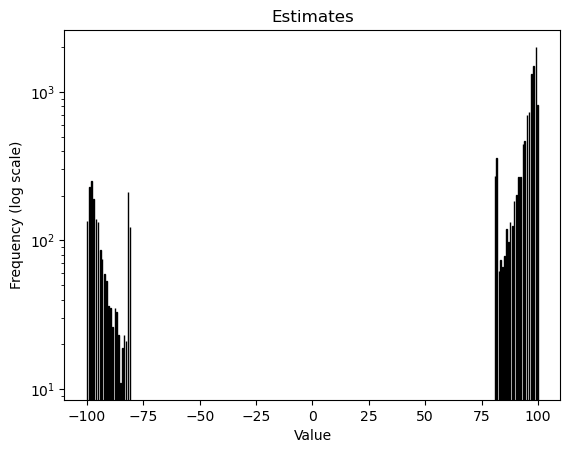

In [16]:
import matplotlib.pyplot as plt



# Plot histogram with y-axis on a logarithmic scale
plt.hist(estimates, bins=1000, log=True, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Estimates')
plt.show()

In [17]:
rhos = np.load('rhos.npy')

In [18]:
rhos.mean()

126496.50615991898

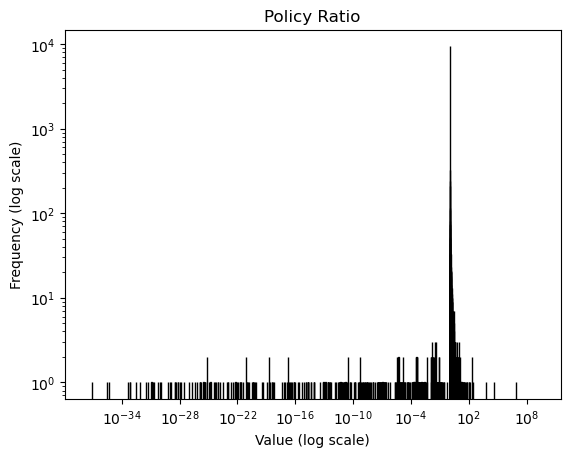

In [19]:

# Create logarithmically spaced bins for the x-axis
bins = np.logspace(np.log10(rhos.min()), np.log10(rhos.max()), 10000)

# Plot the histogram:
# - bins: use logarithmically spaced bins
# - log=True: y-axis is logarithmic
plt.hist(rhos, bins=bins, edgecolor='black', log=True)

# Set x-axis to logarithmic scale
plt.xscale('log')

plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Policy Ratio')

# Save the plot if desired
plt.savefig('log_log_histogram.png')

plt.show()

In [ ]:
import os

import numpy as np
import pandas as pd

from dice_rl_TU_Vienna.value import get_get_policy_value_dataframe
from dice_rl_TU_Vienna.runners.tabular_dice_runner import TabularDiceRunner_Dataframe

In [20]:
def make_DICE_Df(records, model_probs, phys_probs, path=None):
    """
    Creates a DataFrame for DICE analysis by adding probability columns
    and saves it as a parquet file.

    In this version, model_probs and phys_probs represent the probability 
    for the observed action in dice_df['action']. Specifically:
      - If action == 0, then the provided probability is for action 0,
        and the probability for action 1 is 1 - probability.
      - If action == 1, then the provided probability is for action 1,
        and the probability for action 0 is 1 - probability.

    Parameters:
    -----------
    records : pd.DataFrame
        The input DataFrame containing the records.
    model_probs : array-like
        Probabilities corresponding to the action in the model's policy.
    phys_probs : array-like
        Probabilities corresponding to the action in the physician's policy.
    path : str, optional
        Directory path where the parquet file will be saved.
        Defaults to the current directory.

    Returns:
    --------
    pd.DataFrame
        The modified DataFrame with added probability columns.
    """
    import pandas as pd
    import numpy as np
    import os

    # Make a copy to avoid modifying the original DataFrame
    dice_df = records.copy()

    # Align probabilities with the DataFrame's index
    model_probs = pd.Series(model_probs, index=dice_df.index)
    phys_probs = pd.Series(phys_probs, index=dice_df.index)

    dice_df["action"] = dice_df["action"].replace(-1, np.nan)
    
    # Fill NaN values with the previous valid action
    dice_df["action"] = dice_df["action"].fillna(method="ffill")

    dice_df["action"] = dice_df["action"].astype(int)

    # For the model's probabilities: if action==0, p0 is the provided prob;
    # if action==1, then p1 is the provided prob.
    dice_df['p0_model'] = np.where(dice_df['action'] == 0, model_probs, 1.0 - model_probs)
    dice_df['p1_model'] = np.where(dice_df['action'] == 1, model_probs, 1.0 - model_probs)
    dice_df['probabilities_model'] = dice_df[['p0_model', 'p1_model']].values.tolist()

    # For the physician's probabilities: similarly, interpret the provided prob
    dice_df['p0_phys'] = np.where(dice_df['action'] == 0, phys_probs, 1.0 - phys_probs)
    dice_df['p1_phys'] = np.where(dice_df['action'] == 1, phys_probs, 1.0 - phys_probs)
    dice_df['probabilities_phys'] = dice_df[['p0_phys', 'p1_phys']].values.tolist()

    # Handle the file path: default to current working directory if none provided
    if path is None:
        path = os.getcwd()

    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)

    # Full path to save the parquet file
    file_path = os.path.join(path, 'DICE_df_mimic.parquet')

    # Save the DataFrame to a parquet file
    dice_df.to_parquet(file_path)

    return dice_df

In [21]:
dice_df= make_DICE_Df(records, model_probs, phys_probs, path=data_dir)

/tmp/ipykernel_2829916/2656048954.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dice_df["action"] = dice_df["action"].fillna(method="ffill")


In [22]:
dice_df.iloc[150:200]

,bloc,icustayid,state,action,outcome,reward,p0_model,p1_model,probabilities_model,p0_phys,p1_phys,probabilities_phys
150,18,30014019,464,0,1,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
151,19,30014019,464,0,1,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
152,20,30014019,464,0,1,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
153,21,30014019,464,0,1,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
154,22,30014019,464,0,1,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
155,23,30014019,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
156,1,30015055,370,0,0,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
157,2,30015055,94,0,0,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
158,3,30015055,59,0,0,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.980110,0.019890,"[0.9801098901098901, 0.019890109890109864]"
159,4,30015055,433,0,0,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"


In [24]:
dice_df[dice_df['state']==500]

,bloc,icustayid,state,action,outcome,reward,p0_model,p1_model,probabilities_model,p0_phys,p1_phys,probabilities_phys
16,2,30002012,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.963243,0.036757,"[0.9632432432432433, 0.036756756756756714]"
92,23,30006983,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
98,3,30007228,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
109,4,30011624,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
132,11,30013468,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
...,...,...,...,...,...,...,...,...,...,...,...,...
124050,3,39964062,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.871726,0.128274,"[0.8717256637168141, 0.12827433628318585]"
124083,4,39965256,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.845021,0.154979,"[0.8450209205020921, 0.1549790794979079]"
124204,5,39977970,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"
124310,10,39984456,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.990000,0.010000,"[0.99, 0.010000000000000009]"


In [25]:
dice_df[dice_df['icustayid']==30002012]

,bloc,icustayid,state,action,outcome,reward,p0_model,p1_model,probabilities_model,p0_phys,p1_phys,probabilities_phys
15,1,30002012,352,0,1,0,0.99,0.01,"[0.99, 0.010000000000000009]",0.963243,0.036757,"[0.9632432432432433, 0.036756756756756714]"
16,2,30002012,500,0,1,-100,0.99,0.01,"[0.99, 0.010000000000000009]",0.963243,0.036757,"[0.9632432432432433, 0.036756756756756714]"


In [ ]:
dice_old = pd.read_parquet('/home/lkapral/RRT_mimic_iv/data/model/DICE_df_MIMIC.parquet')

In [ ]:
def get_split_general(df, kind):
    id = df["icustayid"]
    obs = df["state"]
    act = df["action"]
    rew = df["reward"]
    if kind == "b": k = "probabilities_phys"
    if kind == "e": k = "probabilities_model"
    probs = df[k]

    return id, obs, act, rew, probs

get_split_b = lambda df: get_split_general(df, "b")
get_split_e = lambda df: get_split_general(df, "e")

def get_episode(df, id):
    f = df["icustayid"] == id
    return df[f]

bounds = 0, model.n_cluster_states+1, 0, 1

In [ ]:
# prepare DICE

# ---------------------------------------------------------------- #

sub_dir = "behavior_MIMIC"
get_split = get_split_b

runner_b = TabularDiceRunner_Dataframe(
    dice_df, bounds, get_split, get_episode, data_dir, sub_dir )

runner_b.set_dataset(n_pads=1)
runner_b.set_aux_estimates()
runner_b.set_estimator("TabularDice")

def get_policy_value_DICE_b_s(gamma):
    pv_DICE, *_ = runner_b.predict(gamma, projected=True, weighted=False, modified=True, lam=1e-6)
    return pv_DICE

def get_policy_value_DICE_b_w(gamma):
    pv_DICE, *_ = runner_b.predict(gamma, projected=True, weighted=True, modified=True, lam=1e-6)
    return pv_DICE

# ---------------------------------------------------------------- #

sub_dir = "evaluation_MIMIC"
get_split = get_split_e

runner_e = TabularDiceRunner_Dataframe(
    dice_df, bounds, get_split, get_episode, data_dir, sub_dir )

runner_e.set_dataset(n_pads=1)
runner_e.set_aux_estimates()
runner_e.set_estimator("TabularDice")

def get_policy_value_DICE_e_s(gamma):
    pv_DICE, *_ = runner_e.predict(gamma, projected=True, weighted=False, modified=True, lam=1e-6)
    return pv_DICE

def get_policy_value_DICE_e_w(gamma):
    pv_DICE, *_ = runner_e.predict(gamma, projected=True, weighted=True, modified=True, lam=1e-6)
    return pv_DICE

# ---------------------------------------------------------------- #

In [ ]:
# prepare OnPE

get_policy_value_OnPE_b, _ = get_get_policy_value_dataframe(dice_df, get_split, get_episode)

In [ ]:
gamma = 0.999

pv_1 = get_policy_value_DICE_b_s(gamma)
pv_2 = get_policy_value_DICE_b_w(gamma)
pv_3 = get_policy_value_OnPE_b(gamma)

print( float(pv_1), float(pv_2), float(pv_3) )

pv_1 = get_policy_value_DICE_e_s(gamma)
pv_2 = get_policy_value_DICE_e_w(gamma)

print( float(pv_1), float(pv_2) )

# Transistion probabilities

In [ ]:
A = model.n_actions
S = model.n_states
transition_matrix_train = model.transitionr
transition_matrix_test = transitionr_test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

# Assuming model.transitionr and transitionr_test are NumPy arrays
A = model.n_actions
S = model.n_states
transition_matrix_train = model.transitionr        # Shape: (752, 752, 2)
transition_matrix_test = transitionr_test          # Shape: (752, 752, 2)

# Validate shapes
assert transition_matrix_train.shape == transition_matrix_test.shape, "Train and Test matrices must have the same shape."

print(f"Number of States (S): {S}")
print(f"Number of Actions (A): {A}")
print(f"Transition Matrix Train Shape: {transition_matrix_train.shape}")
print(f"Transition Matrix Test Shape: {transition_matrix_test.shape}\n")



In [ ]:
assert transition_matrix_train.shape == transition_matrix_test.shape, "Train and Test matrices must have the same shape."

print(f"Number of States (S): {S}")
print(f"Number of Actions (A): {A}")
print(f"Transition Matrix Train Shape: {transition_matrix_train.shape}")
print(f"Transition Matrix Test Shape: {transition_matrix_test.shape}\n")



import numpy as np
from scipy.spatial.distance import jensenshannon
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 2. Normalize Transition Matrices
# ==============================


print("Normalizing transition matrices...")
transition_matrix_train_normalized = transition_matrix_train.copy()
transition_matrix_test_normalized = transition_matrix_test.copy()
print("Normalization complete.\n")

# ==============================
# 3. Check for NaN Values
# ==============================

train_nan = np.isnan(transition_matrix_train_normalized).any()
test_nan = np.isnan(transition_matrix_test_normalized).any()

if train_nan or test_nan:
    print("NaN values detected in the normalized matrices.")
    # Replace NaNs with zeros
    transition_matrix_train_normalized = np.nan_to_num(transition_matrix_train_normalized)
    transition_matrix_test_normalized = np.nan_to_num(transition_matrix_test_normalized)
    print("NaN values have been replaced with zeros.\n")
else:
    print("No NaN values detected in the normalized matrices.\n")

# ==============================
# 4. Compute Similarity Metrics
# ==============================

print("Computing similarity metrics...\n")

frobenius_norms = []
js_divergences = []
tv_distances = []

for a in range(A):
    print(f"Action {a+1}/{A}")
    
    # Frobenius Norm
    diff = transition_matrix_train_normalized[:, :, a] - transition_matrix_test_normalized[:, :, a]
    fro_norm = norm(diff)
    frobenius_norms.append(fro_norm)
    print(f"  Frobenius Norm: {fro_norm:.6f}")
    
    # Jensen-Shannon Divergence
    # Add small epsilon to avoid log(0)
    epsilon = 1e-12
    p = transition_matrix_train_normalized[:, :, a] + epsilon
    q = transition_matrix_test_normalized[:, :, a] + epsilon
    
    # Re-normalize to ensure rows sum to 1 after epsilon addition
    p /= p.sum(axis=0, keepdims=True)
    q /= q.sum(axis=0, keepdims=True)
    
    # Compute JSD for each state
    js_div_per_state = []
    for s in range(S):
        js_div = jensenshannon(p[s], q[s], base=np.e)
        js_div_per_state.append(js_div)
    average_js_div = np.mean(js_div_per_state)
    js_divergences.append(average_js_div)
    print(f"  Average JSD: {average_js_div:.6f}")
    
    # Total Variation Distance
    tv_per_state = 0.5 * np.sum(np.abs(p - q), axis=0)  # Shape: (S,)
    average_tv = np.mean(tv_per_state)
    tv_distances.append(average_tv)
    print(f"  Average TV Distance: {average_tv:.6f}\n")

print("Similarity metrics computation complete.\n")

for a in range(A):
    print(f"Action {a+1}:")
    print(f"  Frobenius Norm: {frobenius_norms[a]:.6f}")
    print(f"  Average JSD: {js_divergences[a]:.6f}")
    print(f"  Average TV Distance: {tv_distances[a]:.6f}\n")

    
from scipy.stats import entropy

# Ensure no zeros in the matrices
epsilon = 1e-10
transition_matrix_train_normalized += epsilon
transition_matrix_test_normalized += epsilon

kl_divergences = entropy(transition_matrix_train_normalized, transition_matrix_test_normalized, axis=0)
average_kl_divergence = np.mean(kl_divergences)
print('Average KL Divergence:', average_kl_divergence)


In [ ]:
records.loc[records['action']==-1,'action'] = 0

In [ ]:
actions = records['action']

In [ ]:
# Check if MIMICraw exists
if 'MIMICraw' not in globals():
    raise NameError("MIMICraw DataFrame is not defined. Please load it before merging.")

MIMICraw[records.columns] = records
MIMICzs[records.columns] = records

full_data_raw = MIMICraw.copy()
full_data_zs = MIMICzs.copy()

MIMICraw.drop(columns=records.columns, inplace=True)
MIMICzs.drop(columns=records.columns, inplace=True)
# Validate the merge

In [ ]:
RRT_counts = full_data_raw.groupby('state')['RRT'].value_counts().unstack(fill_value=0).reset_index(drop=True).reset_index(drop=True)

# Display the resulting counts
print(RRT_counts)

In [ ]:

RRT_counts.loc[RRT_counts[1]>5,:]

# Action distribution

In [ ]:
action_counts = np.bincount(actions, minlength=2)
action_percentages = action_counts / len(actions)

optimal_actions = model.Q.argmax(axis=1)  # AI's recommended actions
optimal_action_counts = np.bincount(optimal_actions, minlength=2)
optimal_action_percentages = optimal_action_counts / len(optimal_actions)

mortality_rates = []
for action_value in [0, 1]:
    indices = np.where(actions == action_value)
    mortality = outcomes[indices]
    mortality_rate = np.mean(mortality)
    mortality_rates.append(mortality_rate)

In [ ]:
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['/home/lkapral/RRT_mimic_iv']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

sns.set(style="ticks", palette="pastel")


state_to_optimal_action = {state: action for state, action in enumerate(optimal_actions)}

# Apply the mapping to each record's state to get AI's action
records['ai_action'] = records['state'].map(state_to_optimal_action)

# Validate the mapping
if records['ai_action'].isnull().any():
    missing_states = records[records['ai_action'].isnull()]['state'].unique()
    raise ValueError(f"Missing optimal actions for states: {missing_states}")

# ------------------------
# Step 3: Aggregate Data at Patient Level
# ------------------------
# Replace action -1 with 0 (assuming -1 represents 'No RRT')
records['action'] = records['action'].replace(-1, 0)

# Aggregate actions and outcomes at the patient level
patient_actions = records.groupby('icustayid').agg({
    'action': lambda x: int((x == 1).any()),        # Clinician administered RRT at any time
    'ai_action': lambda x: int((x == 1).any()),     # AI recommends RRT at any time
    'outcome': 'first'                              # Patient outcome (assumed consistent across time steps)
}).reset_index()

# Rename columns for clarity
patient_actions.rename(columns={'action': 'clinician_rrt', 'ai_action': 'ai_rrt'}, inplace=True)

# ------------------------
# Step 4: Compute Action Distributions
# ------------------------
# Time Steps Action Distribution
# Clinician
clinician_time_steps_rrt = (records['action'] == 1).sum()
total_time_steps = len(records)
clinician_time_steps_proportion = clinician_time_steps_rrt / total_time_steps*100

# AI
ai_time_steps_rrt = (records['ai_action'] == 1).sum()
ai_time_steps_proportion = ai_time_steps_rrt / total_time_steps*100

# Patient-Level Action Distribution
# Clinician
clinician_patient_rrt = patient_actions['clinician_rrt'].sum()
total_patients = len(patient_actions)
clinician_patient_proportion = clinician_patient_rrt / total_patients*100

# AI
ai_patient_rrt = patient_actions['ai_rrt'].sum()
ai_patient_proportion = ai_patient_rrt / total_patients*100

# ------------------------
# Step 5: Prepare Data for Plotting
# ------------------------
# Organize the data into a dictionary for easier handling
plot_data = {
    'Time steps': {
        'Clinician-initiated RRT': (clinician_time_steps_proportion, clinician_time_steps_rrt),
        'AI-recommended RRT': (ai_time_steps_proportion, ai_time_steps_rrt)
    },
    'Patients': {
        'Clinician-initiated RRT': (clinician_patient_proportion, clinician_patient_rrt),
        'AI-recommended RRT': (ai_patient_proportion, ai_patient_rrt)
    }
}

categories = list(plot_data.keys())  # ['Time steps', 'Patients']
methods = ['Clinician-initiated RRT', 'AI-recommended RRT']

# ------------------------
# Step 6: Plot Combined Action Distributions
# ------------------------
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams['font.family'] = 'Helvetica'
# ------------------------
# Set bar width and positions
bar_width = 0.35
index = np.arange(len(categories))  # [0, 1]

# Extract data for plotting
clinician_values = [plot_data[cat]['Clinician-initiated RRT'][0] for cat in categories]
ai_values = [plot_data[cat]['AI-recommended RRT'][0] for cat in categories]

clinician_counts = [plot_data[cat]['Clinician-initiated RRT'][1] for cat in categories]
ai_counts = [plot_data[cat]['AI-recommended RRT'][1] for cat in categories]

colors = {
    
    'Clinician-initiated RRT': '#d0d9f0',          # Keeps the calming and professional feel
    'AI-recommended RRT': '#6b8ac5'                     # Replaces 'salmon' with a trustworthy color
}

# Create bars
bars1 = ax.bar(index - bar_width/2, clinician_values, bar_width, label='Clinician-initiated RRT', color=colors['Clinician-initiated RRT'])
bars2 = ax.bar(index + bar_width/2, ai_values, bar_width, label='AI-recommended RRT', color=colors['AI-recommended RRT'])

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Category')
ax.set_ylabel('Proportion of patients receiving RRT (%)')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

# Function to add percentage and count labels on top of each bar
def add_percentage_count_labels(bars, counts):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        # Calculate the position for the annotation
        ax.annotate(f'{round(height,1)}%\nn = {count}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

# Add percentage and count labels to each bar
add_percentage_count_labels(bars1, clinician_counts)
add_percentage_count_labels(bars2, ai_counts)

# Add grid for better readability
ax.yaxis.grid(True)

# ------------------------
# Step 7: Adjust Y-axis Limits to Accommodate Annotations
# ------------------------
# Find the maximum bar height
max_bar = max(max(clinician_values, ai_values))
# Set y-axis limit to 1.2 times the maximum bar height or at least 1.0
y_max = max_bar * 1.2 if max_bar * 1.2 < 100 else 100

ax.set_ylim(0, y_max)


# Adjust layout to make room for the annotations
plt.tight_layout(rect=[0, 0.25, 1, 0.95])

# Change the default font to Helvetica

# Step 9: Display the Plot
# ------------------------
plt.show()

# ------------------------
fig_path = os.path.join(output_dir, "evaluation_results")
os.makedirs(fig_path, exist_ok=True)

# Save the figure
fig.savefig(os.path.join(fig_path, "mimic_actions_timesteps.png"), dpi=300)
fig.savefig(os.path.join(fig_path, "mimic_actions_timesteps.eps"))
plt.close(fig)


In [ ]:
fig_path

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Make sure to import os if not already

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming `full_data_raw` is your DataFrame containing the ICU patient data
# and `optimal_actions` is a list or array of optimal actions mapped by state.

# ===========================
# 1. Create a Mapping from State to AI's Optimal Action
# ===========================
sns.set(style="ticks", palette="pastel")
state_to_optimal_action = {state: action for state, action in enumerate(optimal_actions)}

# ===========================
# 2. Aggregate Data Per Patient to Identify RRT Occurrences
# ===========================

# Define what constitutes an RRT action
# Assuming that 'action' and 'ai_action' are numerical, where >= 0.5 indicates RRT
RRT_THRESHOLD = 0.5

# First, map AI actions based on state for all records
full_data_raw['ai_action'] = full_data_raw['state'].map(state_to_optimal_action)

# Validate the mapping
if full_data_raw['ai_action'].isnull().any():
    missing_states = full_data_raw[full_data_raw['ai_action'].isnull()]['state'].unique()
    raise ValueError(f"Missing optimal actions for states: {missing_states}")

# Identify if RRT was ever performed by Clinicians and AI for each patient
patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x >= RRT_THRESHOLD).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x >= RRT_THRESHOLD).any()),
    max_SOFA=('SOFA', 'max')
).reset_index()

# ===========================
# 3. Categorize SOFA Scores
# ===========================

# Define SOFA groups
bins = [0, 4, 9, 14, 20]
labels = ['0-4 (low)', '5-9 (moderate)', '10-14 (high)', '>15 (very high)']
patient_rrt['SOFA_group'] = pd.cut(patient_rrt['max_SOFA'], bins=bins, labels=labels, include_lowest=True)

# Handle any SOFA scores outside the defined bins
if patient_rrt['SOFA_group'].isnull().any():
    print("Warning: Some patients have SOFA scores outside the defined bins. These will be excluded from grouping.")

    patient_rrt = patient_rrt.dropna(subset=['SOFA_group'])


# Group by SOFA_group and compute proportions and counts
action_distributions_sofa = patient_rrt.groupby('SOFA_group').agg(
    clinician_rrt_proportion=('clinician_rrt_occurred', 'mean'),
    ai_rrt_proportion=('ai_rrt_occurred', 'mean'),
    patient_count=('icustayid', 'count')  # Count of patients per SOFA group
).reset_index()

# Calculate counts for Clinician RRT and AI RRT based on proportions
action_distributions_sofa['clinician_rrt_count'] = (action_distributions_sofa['clinician_rrt_proportion'] * action_distributions_sofa['patient_count']).round().astype(int)
action_distributions_sofa['ai_rrt_count'] = (action_distributions_sofa['ai_rrt_proportion'] * action_distributions_sofa['patient_count']).round().astype(int)

# ===========================
# 5. Visualization
# ===========================

# Parameters for the plot
SOFA_groups = action_distributions_sofa['SOFA_group']
n_groups = len(SOFA_groups)
index = np.arange(n_groups)
bar_width = 0.35  # Width of the bars
opacity = 0.8

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Change the default font to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# Plotting the "Clinician-initiated RRT" and "AI-recommended RRT" bars
rects1 = ax.bar(index - bar_width/2, action_distributions_sofa['clinician_rrt_proportion']*100,
                bar_width, alpha=opacity, color='#d0d9f0', label='Clinican-initiated RRT')

rects2 = ax.bar(index + bar_width/2, action_distributions_sofa['ai_rrt_proportion']*100,
                bar_width, alpha=opacity, color='#6b8ac5', label='AI-recommended RRT')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('SOFA Group', fontsize=12)
ax.set_ylabel('Proportion of patients receiving RRT (%)', fontsize=12)

ax.set_ylim(0, 110)  # Increased to accommodate patient counts

# Adding grid lines for better readability
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Removing top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding legend
ax.legend()

def add_percentage_count_labels(bars, counts):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        # Calculate the position for the annotation
        ax.annotate(f'{round(height,1)}%\nn = {count}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

# Apply the function to both sets of bars
add_percentage_count_labels(rects1, action_distributions_sofa['clinician_rrt_count'])
add_percentage_count_labels(rects2, action_distributions_sofa['ai_rrt_count'])

# Modify x-ticks to have only 3 ticks
desired_ticks = 4

if n_groups > desired_ticks:
    # Select first, second, and last tick positions
    tick_indices = [0, 1, n_groups - 1]
    tick_labels = [SOFA_groups[i] for i in tick_indices]
    ax.set_xticks(index[tick_indices])
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=10)
else:
    # If 3 or fewer groups, display all
    ax.set_xticks(index)
    ax.set_xticklabels(SOFA_groups, rotation=45, fontsize=10)

# Improve layout to prevent clipping of tick-labels and annotations
plt.tight_layout()

fig.savefig(os.path.join(fig_path, "mimic_SOFA_actions.png"), dpi=300)
fig.savefig(os.path.join(fig_path, "mimic_SOFA_actions.eps"))
# Display the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_rrt_by_icu_group(full_data_raw, optimal_actions, icustays_csv_path):
    sns.set(style="ticks", palette="pastel")
    """
    Analyze and visualize RRT occurrences by ICU group for Clinician and AI actions.

    Parameters:
    - full_data_raw (pd.DataFrame): DataFrame containing ICU patient data with columns such as
                                     'icustayid', 'state', 'action', 'SOFA', etc.
    - optimal_actions (list or np.array): List/array where each index corresponds to a state,
                                          representing the AI's optimal action.
    - icustays_csv_path (str): File path to the 'icustays.csv' file.

    Returns:
    - None: Displays a bar plot comparing Clinician and AI-recommended RRT occurrences by ICU group.
    """
    
    # ===========================
    # 1. Create a Mapping from State to AI's Optimal Action
    # ===========================
    
    # Ensure that 'optimal_actions' is defined and corresponds to all possible states
    state_to_optimal_action = {state: action for state, action in enumerate(optimal_actions)}
    
    # ===========================
    # 2. Load and Merge ICU Stays Data
    # ===========================
    
    try:
        icustays = pd.read_csv(icustays_csv_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"ICU stays data file not found at: {icustays_csv_path}")
    if 'first_careunit' not in( full_data_raw.columns):
        # Merge full_data_raw with icustays on 'icustayid' and 'stay_id'
        merged = full_data_raw.merge(
            icustays[['stay_id', 'first_careunit']],
            how='left',
            left_on='icustayid',
            right_on='stay_id'
        )
        
        
        # Assign the 'first_careunit' to full_data_raw
        full_data_raw['first_careunit'] = merged['first_careunit']
    
    # ===========================
    # 3. Define and Map ICU Groups
    # ===========================
    
    # Define ICU group mappings
    careunit_to_group = {
        'Medical Intensive Care Unit (MICU)': 'Medical',
        'Coronary Care Unit (CCU)': 'Medical',
        'Neuro Intermediate': 'Surgical',
        'Medicine': 'Medical',
        'Med/Surg': 'Mixed',
        'Medicine/Cardiology Intermediate': 'Medical',
        'Neurology': 'Surgical',
        'Neuro Stepdown': 'Surgical',
        'Cardiac Vascular Intensive Care Unit (CVICU)': 'Surgical',
        'Surgical Intensive Care Unit (SICU)': 'Surgical',
        'Trauma SICU (TSICU)': 'Surgical',
        'Neuro Surgical Intensive Care Unit (Neuro SICU)': 'Surgical',
        'Surgery/Vascular/Intermediate': 'Mixed',
        'PACU': 'Surgical',
        'Intensive Care Unit (ICU)': 'Surgical',
        'Surgery/Trauma': 'Surgical',
        'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'Mixed'
    }
    
    # Map 'first_careunit' to 'ICU_group'
    full_data_raw['ICU_group'] = full_data_raw['first_careunit'].map(careunit_to_group)
    
    # Handle any missing ICU groups
    if full_data_raw['ICU_group'].isnull().any():
        missing_careunits = full_data_raw[full_data_raw['ICU_group'].isnull()]['first_careunit'].unique()
        print(f"Warning: The following care units are not mapped to an ICU group and will be excluded: {missing_careunits}")
        # Exclude records with unmapped 'first_careunit'
        full_data_raw = full_data_raw.dropna(subset=['ICU_group'])
    
    # ===========================
    # 4. Map States to AI Actions
    # ===========================
    
    # Map the state to AI's action for all records
    full_data_raw['ai_action'] = full_data_raw['state'].map(state_to_optimal_action)
    
    # Validate the mapping
    if full_data_raw['ai_action'].isnull().any():
        missing_states = full_data_raw[full_data_raw['ai_action'].isnull()]['state'].unique()
        raise ValueError(f"Missing optimal actions for states: {missing_states}")
    
    # ===========================
    # 5. Aggregate Data Per Patient to Identify RRT Occurrences
    # ===========================
    
    # Identify if RRT was ever performed by Clinicians and AI for each patient
    patient_rrt = full_data_raw.groupby('icustayid').agg(
        clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
        ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
        ICU_group=('ICU_group', 'first')  # Assuming ICU_group is consistent per patient
    ).reset_index()
    
    # ===========================
    # 6. Compute Action Distributions and Patient Counts
    # ===========================
    
    # Group by ICU_group and compute proportions and counts
    action_distributions_icu = patient_rrt.groupby('ICU_group').agg(
        clinician_rrt_proportion=('clinician_rrt_occurred', 'mean'),
        ai_rrt_proportion=('ai_rrt_occurred', 'mean'),
        patient_count=('icustayid', 'count')  # Count of patients per ICU group
    ).reset_index()
    
    # Calculate counts for Clinician-initiated RRT and AI-recommended RRT based on proportions
    action_distributions_icu['clinician_rrt_count'] = (action_distributions_icu['clinician_rrt_proportion'] * action_distributions_icu['patient_count']).round().astype(int)
    action_distributions_icu['ai_rrt_count'] = (action_distributions_icu['ai_rrt_proportion'] * action_distributions_icu['patient_count']).round().astype(int)
    
    # ===========================
    # 7. Visualization
    # ===========================
    
    # Parameters for the plot
    ICU_groups = action_distributions_icu['ICU_group']
    n_groups = len(ICU_groups)
    index = np.arange(n_groups)
    bar_width = 0.35  # Width of the bars
    opacity = 0.8
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    # Change the default font to Helvetica
    plt.rcParams['font.family'] = 'Helvetica'

    
    rects1 = ax.bar(index - bar_width/2, action_distributions_icu['clinician_rrt_proportion']*100,
                    bar_width, alpha=opacity, color='#d0d9f0', label='Clinician-initiated RRT')
    
    rects2 = ax.bar(index + bar_width/2, action_distributions_icu['ai_rrt_proportion']*100,
                    bar_width, alpha=opacity, color='#6b8ac5', label='AI-recommended RRT')
    
    # Adding labels, title, and custom x-axis tick labels
    ax.set_xlabel('ICU Group', fontsize=12)
    ax.set_ylabel('Proportion of patients receiving RRT (%)', fontsize=12)

    ax.set_xticklabels(ICU_groups, rotation=45, fontsize=10)
    ax.set_ylim(0, 15)  # Increased to accommodate patient counts
    
    # Adding grid lines for better readability
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
    
    # Removing top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    desired_ticks = 3
    
    if n_groups > desired_ticks:
        # Select first, second, and last tick positions
        tick_indices = [0, 1, n_groups - 1]
        tick_labels = [ICU_groups[i] for i in tick_indices]
        ax.set_xticks(index[tick_indices])
        ax.set_xticklabels(tick_labels, rotation=45, fontsize=10)
    else:
        # If 3 or fewer groups, display all
        ax.set_xticks(index)
        ax.set_xticklabels(ICU_groups, rotation=45, fontsize=10)
        
        # Adding legend
        ax.legend()
    
    def add_percentage_count_labels(bars, counts):
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            # Calculate the position for the annotation
            ax.annotate(f'{round(height,1)}%\nn = {count}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),  # 5 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=9)
    
    # Apply the function to both sets of bars
    add_percentage_count_labels(rects1, action_distributions_icu['clinician_rrt_count'])
    add_percentage_count_labels(rects2, action_distributions_icu['ai_rrt_count'])
    
    # Improve layout to prevent clipping of tick-labels and annotations
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    fig.savefig(os.path.join(fig_path, "mimic_ICU_actions.png"), dpi=300)
    fig.savefig(os.path.join(fig_path, "mimic_ICU_actions.eps"))

    return action_distributions_icu

    
# Mock icustays.csv DataFrame
careunits = [
    'Medical Intensive Care Unit (MICU)', 'Coronary Care Unit (CCU)',
    'Neuro Intermediate', 'Medicine', 'Med/Surg', 'Medicine/Cardiology Intermediate',
    'Neurology', 'Neuro Stepdown', 'Cardiac Vascular Intensive Care Unit (CVICU)',
    'Surgical Intensive Care Unit (SICU)', 'Trauma SICU (TSICU)',
    'Neuro Surgical Intensive Care Unit (Neuro SICU)', 'Surgery/Vascular/Intermediate',
    'PACU', 'Intensive Care Unit (ICU)', 'Surgery/Trauma',
    'Medical/Surgical Intensive Care Unit (MICU/SICU)'
]

icu_stay_id_dir = '/home/lkapral/RRT_mimic_iv/data/icustays.csv'
# ===========================
# 2. Execute the Analysis Function
# ===========================

action_distributions_icu =analyze_rrt_by_icu_group(full_data_raw, optimal_actions, icu_stay_id_dir)



In [ ]:
action_counts = np.bincount(actions, minlength=2)

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame
df = full_data_raw

# Group where action is at least 1
action_at_least_1 = df[df['action'] >= 1].groupby('icustayid')['bloc'].max().reset_index()
action_at_least_1['group'] = 'at_least_1'

# Group where action is always 0
action_always_0 = df.groupby('icustayid').filter(lambda x: (x['action'] == 0).all())
action_always_0 = action_always_0.groupby('icustayid')['bloc'].max().reset_index()
action_always_0['group'] = 'always_0'

# Combine both groups into a single DataFrame for comparison
comparison_df = pd.concat([action_at_least_1, action_always_0])

# Optional: Pivot for easier comparison
pivot_df = comparison_df.pivot(index='icustayid', columns='group', values='bloc')

print(pivot_df)


In [ ]:
all_patients = full_data_raw.groupby('icustayid')['bloc'].max().reset_index()
all_patients['group'] = 'always_0'

In [ ]:
all_patients.describe()

In [ ]:
# Compute AI bot's recommended actions
optimal_actions = model.Q.argmax(axis=1)  # Optimal action per state

# Map states to AI bot's recommended actions
ai_recommended_actions = optimal_actions[states]

# Determine concordance
concordant = (actions == ai_recommended_actions).astype(int)

# Calculate concordance rate
concordance_rate = np.mean(concordant)
print(f"Concordance Rate between clinician and AI bot: {concordance_rate:.2%}")

# Add concordance information to records
records['concordant'] = concordant

# Visualize Concordance Distribution
fig_concordance = plt.figure(figsize=(8, 6))
concordance_counts = np.bincount(concordant, minlength=2)
concordance_percentages = concordance_counts / len(concordant)

plot_concordance = concordance_percentages.copy()
plot_concordance[0] = concordance_percentages[1]
plot_concordance[1] = concordance_percentages[0]

plt.bar(['Concordant', 'Non-Concordant'], plot_concordance, color=['teal', 'red'])
plt.ylabel('Proportion')
plt.title('Concordance between Clinician and AI Bot Actions')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="ticks", palette="pastel")
plt.rcParams['font.family'] = 'Helvetica'

# ------------------------
# Step 1: Aggregate All Necessary Data
# ------------------------

# Assuming you have already performed the following aggregations:
# 1. Time Steps Action Distribution (clinician_time_steps_proportion, ai_time_steps_proportion)
# 2. Patient-Level Action Distribution (clinician_patient_proportion, ai_patient_proportion)
# 3. SOFA Groups Action Distribution (action_distributions_sofa)
# 4. ICU Groups Action Distribution (action_distributions_icu)

# For demonstration, let's create mock data structures based on your provided code.

# 1. Time Steps
time_steps_data = {
    'Category': ['Time steps'] * 2,
    'Method': ['Clinician-initiated RRT', 'AI-recommended RRT'],
    'Proportion': [clinician_time_steps_proportion, ai_time_steps_proportion],
    'Count': [clinician_time_steps_rrt, ai_time_steps_rrt]
}

# 2. Patients
patients_data = {
    'Category': ['Patients'] * 2,
    'Method': ['Clinician-initiated RRT', 'AI-recommended RRT'],
    'Proportion': [clinician_patient_proportion, ai_patient_proportion],
    'Count': [clinician_patient_rrt, ai_patient_rrt]
}

# 3. SOFA Groups
# Assuming 'action_distributions_sofa' DataFrame from SOFA analysis
# with columns: 'SOFA_group', 'clinician_rrt_proportion', 'ai_rrt_proportion', 'clinician_rrt_count', 'ai_rrt_count'

sofa_groups = action_distributions_sofa['SOFA_group'].tolist()
sofa_proportions_clinician = (action_distributions_sofa['clinician_rrt_proportion'] * 100).tolist()
sofa_proportions_ai = (action_distributions_sofa['ai_rrt_proportion'] * 100).tolist()
sofa_counts_clinician = action_distributions_sofa['clinician_rrt_count'].tolist()
sofa_counts_ai = action_distributions_sofa['ai_rrt_count'].tolist()

sofa_data = {
    'Category': sofa_groups * 2,
    'Method': ['Clinician-initiated RRT'] * len(sofa_groups) + ['AI-recommended RRT'] * len(sofa_groups),
    'Proportion': sofa_proportions_clinician + sofa_proportions_ai,
    'Count': sofa_counts_clinician + sofa_counts_ai
}

# 4. ICU Groups
# Assuming 'action_distributions_icu' DataFrame from ICU analysis
# with columns: 'ICU_group', 'clinician_rrt_proportion', 'ai_rrt_proportion', 'clinician_rrt_count', 'ai_rrt_count'

icu_groups = action_distributions_icu['ICU_group'].tolist()
icu_proportions_clinician = (action_distributions_icu['clinician_rrt_proportion'] * 100).tolist()
icu_proportions_ai = (action_distributions_icu['ai_rrt_proportion'] * 100).tolist()
icu_counts_clinician = action_distributions_icu['clinician_rrt_count'].tolist()
icu_counts_ai = action_distributions_icu['ai_rrt_count'].tolist()

icu_data = {
    'Category': icu_groups * 2,
    'Method': ['Clinician-initiated RRT'] * len(icu_groups) + ['AI-recommended RRT'] * len(icu_groups),
    'Proportion': icu_proportions_clinician + icu_proportions_ai,
    'Count': icu_counts_clinician + icu_counts_ai
}

# Combine all data into a single DataFrame
# To ensure SOFA comes after ICU, concatenate in the desired order
combined_data = pd.concat([
    pd.DataFrame(time_steps_data),
    pd.DataFrame(patients_data),
    pd.DataFrame(icu_data),
    pd.DataFrame(sofa_data)
], ignore_index=True)

# ------------------------
# Step 2: Plot the Combined Bar Chart
# ------------------------

# Define the desired order of categories
# Remove 'sorted()' to maintain the original order of ICU and SOFA groups
desired_order = ['Patients', 'Time steps'] + icu_groups + sofa_groups

# Reorder the combined_data DataFrame
combined_data['Category'] = pd.Categorical(combined_data['Category'], categories=desired_order, ordered=True)
combined_data = combined_data.sort_values('Category')

# Determine unique categories and methods
unique_categories = combined_data['Category'].cat.categories
unique_methods = combined_data['Method'].unique()

# Number of categories and methods
n_categories = len(unique_categories)
n_methods = len(unique_methods)

# Define bar width and positions
bar_width = 0.35
index = np.arange(n_categories)

# Initialize the plot
fig, ax = plt.subplots(figsize=(16, 10))  # Adjust figsize as needed

# Define colors for each method
colors = {
    'Clinician-initiated RRT': '#d0d9f0',
    'AI-recommended RRT': '#6b8ac5'
}

# Plot each method
for i, method in enumerate(unique_methods):
    # Extract proportions and counts for the current method
    proportions = combined_data[combined_data['Method'] == method]['Proportion'].values
    counts = combined_data[combined_data['Method'] == method]['Count'].values
    
    # Calculate bar positions
    # Center the bars around each category index
    bar_positions = index + (i - n_methods / 2) * bar_width + bar_width / 2
    
    # Create bars
    bars = ax.bar(bar_positions, proportions, bar_width, label=method, color=colors.get(method, '#333333'),  edgecolor='black', linewidth=1 )
    
    # Add annotations
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{round(height,1)}%\nn = {count}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

# Set y-axis label
ax.set_ylabel('Proportion of RRT (%)', fontsize=14)

# Set x-axis labels and positions
ax.set_xticks(index)
ax.set_xticklabels(unique_categories, rotation=45, ha='center', fontsize=10)  # Reduced fontsize to 10

# Add legend
ax.legend()

# Add grid for y-axis
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Adjust y-axis limits to accommodate annotations
y_max = combined_data['Proportion'].max() * 1.12 if combined_data['Proportion'].max() * 1.12 < 100 else 100
ax.set_ylim(0, y_max)

# ------------------------
# Step 3: Add Group Labels Above Categories
# ------------------------

# Define the main groups and their corresponding categories
# Order adjusted to reflect the desired group names and their categories
main_groups = {
    'Patients': ['Patients'],
    'Time steps': ['Time steps'],
    'Patients (ICU groups)': icu_groups,
    'Patients (SOFA groups)': sofa_groups
}

# Calculate the starting and ending indices for each main group
group_boundaries = {}
current_start = 0
for group, categories in main_groups.items():
    num_categories = len(categories)
    group_boundaries[group] = (current_start, current_start + num_categories - 1)
    current_start += num_categories

# Add group labels
for group, (start, end) in group_boundaries.items():
    # Calculate the center position
    center = (start + end) / 2
    # Adjust the y position based on y_max
    y_pos = y_max * 0.95  # Positioned near the top of the plot
    # Add text
    ax.text(center, y_pos, group, ha='center', va='bottom', fontsize=16, fontweight='bold', color='black')

# Optional: Add spacing above the plot for group labels
plt.subplots_adjust(top=0.85)  # Adjusted to provide more space if needed

# ------------------------
# Step 4: Add Three Vertical Dotted Lines Between Groups
# ------------------------

# Define the positions where the vertical lines should be placed
# After 'Time Steps', after 'Patients', and after 'ICU Groups'

# Calculate the number of categories in each main group
counts = [len(categories) for categories in main_groups.values()]

# Cumulative sum to find the end of each group
cumulative_counts = np.cumsum(counts)

# The vertical lines should be placed between groups, i.e., at positions cumulative_counts[:-1]
# Since each category is centered at index positions, the lines should be placed at cumulative_counts - 0.5
separator_positions = cumulative_counts[:-1] - 0.5

# Add vertical dotted lines
for pos in separator_positions:
    ax.axvline(x=pos, linestyle='--', color='grey', alpha=0.7)

# ------------------------
# Step 5: Improve X-axis Labels (Wrapping Long Labels)
# ------------------------

# If labels are too long, consider abbreviating or wrapping them
# For example, using multi-line labels

def wrap_label(label, width=15):
    if len(label) > width:
        return '\n'.join([label[i:i+width] for i in range(0, len(label), width)])
    else:
        return label

# Apply label wrapping
wrapped_labels = [wrap_label(label) for label in unique_categories]
ax.set_xticklabels(wrapped_labels, rotation=45, ha='center', fontsize=10)  # fontsize reduced to 10

# ------------------------
# Step 6: Final Adjustments and Layout
# ------------------------

# Tight layout to prevent clipping
plt.tight_layout()

# ------------------------
# Step 7: Save and Display the Plot
# ------------------------




# Save the figure in desired formats
fig.savefig(os.path.join(fig_path, "combined_mimic_actions.png"), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(fig_path, "combined_mimic_actions.eps"), bbox_inches='tight' )

# Display the plot
plt.show()


In [ ]:
separator_positions

In [ ]:
# Merge MIMICraw and metadata on index or a common key
merged_df = full_data_raw

# Now, 'icustayid' and 'action' are both in merged_df
# Identify patients who received RRT
rrt_patients = merged_df.loc[merged_df['action'] == 1, C_ICUSTAYID].unique()

if len(rrt_patients) > 0:
    # Select an example patient
    example_patient_id = np.random.choice(rrt_patients)
    print(f"Selected Example Patient ICU Stay ID: {example_patient_id}")

    # Extract patient data
    patient_data = merged_df[merged_df[C_ICUSTAYID] == example_patient_id].copy()

    # Get time steps
    time_steps = patient_data[C_BLOC].values

    # Clinician's actions
    clinician_actions = patient_data['action'].values

    # States
    patient_indices = merged_df[C_ICUSTAYID] == example_patient_id
    patient_states = states[patient_indices]

    # AI bot's recommended actions
    ai_actions = optimal_actions[patient_states]

    # Plot clinician vs. AI actions over time
    fig_patient = plt.figure(figsize=(12, 6))
    plt.step(time_steps, clinician_actions, label='Clinician Action', where='post')
    plt.step(time_steps, ai_actions, label='AI Bot Recommended Action', where='post', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Action (0: No RRT, 1: RRT)')
    plt.title(f'Clinician vs. AI Actions for Patient {example_patient_id}')
    plt.legend()
    plt.show()

    # Optionally, plot key physiological variables (e.g., 'Creatinine')
    if 'Creatinine' in patient_data.columns:
        fig_creatinine = plt.figure(figsize=(12, 6))
        plt.plot(time_steps, patient_data['Creatinine'], label='Creatinine Level', marker='o')
        plt.xlabel('Time Step')
        plt.ylabel('Creatinine Level')
        plt.title(f'Creatinine Levels Over Time for Patient {example_patient_id}')
        plt.legend()
        plt.show()
else:
    print("No patients with RRT found in the dataset.")

    
    

In [ ]:
from scipy.stats import chi2_contingency

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
# Group 1: Patients who received RRT as per clinician
clinician_rrt_indices = np.where(actions == 1)[0]
clinician_rrt_mortality = outcomes[clinician_rrt_indices]
clinician_rrt_mortality_rate = np.mean(clinician_rrt_mortality)
print(f"Clinician-initiated RRT Mortality Rate: {clinician_rrt_mortality_rate:.2%}")

# Group 2: Patients who would receive RRT as per AI bot
ai_rrt_indices = np.where(ai_recommended_actions == 1)[0]
ai_rrt_mortality = outcomes[ai_rrt_indices]
ai_rrt_mortality_rate = np.mean(ai_rrt_mortality)
print(f"AI Bot RRT Mortality Rate: {ai_rrt_mortality_rate:.2%}")

# Statistical Test
# Prepare contingency table
clinician_rrt_deaths = np.sum(clinician_rrt_mortality)
clinician_rrt_survivors = len(clinician_rrt_mortality) - clinician_rrt_deaths
ai_rrt_deaths = np.sum(ai_rrt_mortality)
ai_rrt_survivors = len(ai_rrt_mortality) - ai_rrt_deaths

contingency_table = np.array([
    [clinician_rrt_deaths, clinician_rrt_survivors],
    [ai_rrt_deaths, ai_rrt_survivors]
])

chi2, p_value, _, _ = chi2_contingency(contingency_table)
print(f"Chi-squared Test: chi2 = {chi2:.4f}, p-value = {p_value:.4f}")



# Visualization
fig_mortality = plt.figure(figsize=(8, 6))
mortality_rates = [clinician_rrt_mortality_rate, ai_rrt_mortality_rate]
labels = ['Clinician-initiated RRT', 'AI Bot RRT']
plt.bar(labels, mortality_rates, color=['#6b8ac5', '#0c385c'])
plt.ylabel('Mortality Rate')
plt.title('Mortality Rates of Patients Receiving RRT')
plt.show()


In [ ]:

# # Get unique states
# unique_states = np.unique(states)

# # Initialize lists to store proportions
# clinician_action_proportions = []
# ai_action_proportions = []

# for state in unique_states:
#     # Clinician actions in this state
#     clinician_actions_in_state = actions[states == state]
#     clinician_action_counts = np.bincount(clinician_actions_in_state, minlength=2)
#     total_clinician_actions = clinician_action_counts.sum()
#     if total_clinician_actions > 0:
#         clinician_action_prop = clinician_action_counts / total_clinician_actions
#     else:
#         clinician_action_prop = np.array([0, 0])  # Or np.nan, depending on preference
#     clinician_action_proportions.append(clinician_action_prop)
    
#     # AI actions in this state
#     ai_actions_in_state = ai_recommended_actions[states == state]
#     ai_action_counts = np.bincount(ai_actions_in_state, minlength=2)
#     total_ai_actions = ai_action_counts.sum()
#     if total_ai_actions > 0:
#         ai_action_prop = ai_action_counts / total_ai_actions
#     else:
#         ai_action_prop = np.array([0, 0])
#     ai_action_proportions.append(ai_action_prop)

# # Convert to arrays
# clinician_action_proportions = np.array(clinician_action_proportions)
# ai_action_proportions = np.array(ai_action_proportions)

# # Plotting
# num_states = len(unique_states)
# num_cols = 5  # You can adjust this as needed
# num_rows = int(np.ceil(num_states / num_cols))

# fig_state_actions = plt.figure(figsize=(3 * num_cols, 3 * num_rows))

# for idx, state in enumerate(unique_states):
#     plt.subplot(num_rows, num_cols, idx + 1)
#     bar_width = 0.35
#     index = np.arange(2)
    
#     # Plot clinician action proportions
#     plt.bar(index, clinician_action_proportions[idx], bar_width, label='Clinician')
#     # Plot AI action proportions
#     plt.bar(index + bar_width, ai_action_proportions[idx], bar_width, label='AI Bot')
    
#     plt.title(f'State {state}', fontsize=10)
#     plt.xticks(index + bar_width / 2, ['No RRT', 'RRT'], fontsize=8)
#     plt.yticks(fontsize=8)
#     plt.ylim(0, 1)
    
#     # Add legend only once
#     if idx == 0:
#         plt.legend(fontsize=8)

# plt.tight_layout()
# plt.show()


In [ ]:
metadata.columns

In [ ]:
MIMICraw[metadata.columns] = metadata

In [ ]:
full_data_raw

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from sklearn.metrics import confusion_matrix

# --- Data Preparation ---

# Assuming all necessary data are already defined:
# model, stay_ids, actions, states, blocs, metadata, outcomes, full_data_raw, C_ICUSTAYID, fig_path

# 1. Compute AI's actions for each state
optimal_actions = model.Q.argmax(axis=1)

# 2. Use the new grouping approach based on full_data_raw:
#    Identify if RRT was ever performed by Clinicians and suggested by the AI for each patient.
patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
).reset_index()

# Remove any potential NaN values after mapping
confusion_data = patient_rrt.dropna(subset=['ai_rrt_occurred', 'clinician_rrt_occurred'])

# Create a confusion matrix comparing clinician and AI RRT flags.
# Convert boolean flags to integers for the confusion_matrix function.
cm = confusion_matrix(
    confusion_data['clinician_rrt_occurred'].astype(int), 
    confusion_data['ai_rrt_occurred'].astype(int), 
    labels=[1, 0]
)

cm_df = pd.DataFrame(
    cm, 
    index=['Clinician: RRT', 'Clinician: No RRT'], 
    columns=['AI: RRT', 'AI: No RRT']
)

print("Confusion Matrix:")
print(cm_df)

# Define patient groups based on whether each party ever performed/suggested RRT.
def get_group(row):
    if row['ai_rrt_occurred'] and row['clinician_rrt_occurred']:
        return 'Both RRT'
    elif row['ai_rrt_occurred'] and not row['clinician_rrt_occurred']:
        return 'AI-recommended RRT only'
    elif not row['ai_rrt_occurred'] and row['clinician_rrt_occurred']:
        return 'Clinician-initiated RRT only'
    else:
        return 'Neither RRT'
    
patient_rrt['group'] = patient_rrt.apply(get_group, axis=1)

# 3. Calculate Maximum Bloc per Patient (time to event or censoring)
max_bloc_per_patient = pd.Series(blocs).groupby(stay_ids).max().reset_index()
max_bloc_per_patient.columns = [C_ICUSTAYID, 'max_bloc']

# 4. Determine Global Maximum Bloc (for censoring patients without an event)
global_max_bloc = max_bloc_per_patient['max_bloc'].max()
print(f"Global Maximum Bloc: {global_max_bloc}")

# 5. Assign Survival Time and Event Status
#    Create a dictionary mapping each ICUSTAY_ID to the event (death = 1, survival = 0).
patient_events = {}
unique_patients = np.unique(stay_ids)
for icustay_id in unique_patients:
    event_indices = np.where(metadata[C_ICUSTAYID] == icustay_id)[0]
    if len(event_indices) > 0:
        event = outcomes[event_indices[0]]  # 1 if death occurred, 0 if not
        patient_events[icustay_id] = event
    else:
        patient_events[icustay_id] = np.nan  # Handle missing data appropriately

# 6. Merge Data into a Single DataFrame for Survival Analysis
survival_data = pd.DataFrame({
    C_ICUSTAYID: unique_patients,
    'event': [patient_events[id_] for id_ in unique_patients]
})

# Merge the maximum bloc per patient
survival_data = survival_data.merge(max_bloc_per_patient, on=C_ICUSTAYID, how='left')

# Merge in the patient group information from our new grouping (patient_rrt)
# Make sure the grouping DataFrame has the same patient identifier column name.
survival_data = survival_data.merge(patient_rrt[[C_ICUSTAYID, 'group']], left_on=C_ICUSTAYID, right_on='icustayid', how='left')
#survival_data.drop(columns='icustayid', inplace=True)  # Remove duplicate column if present

# 7. Remove Patients with Missing Events or Group Assignments
survival_data = survival_data.dropna(subset=['event', 'group'])

# 8. Assign Survival Time Based on Event Status
#    If event = 1 (death), use the patient's max_bloc; else, assign a censoring time (e.g., 180 blocs)
survival_data['survival_time'] = np.where(
    survival_data['event'] == 1,
    survival_data['max_bloc'],
    180
)

# Convert survival_time from blocs to days (assuming 1 bloc = 0.5 days; adjust if necessary)
survival_data['time_days'] = survival_data['survival_time'] * 0.5

# 9. Merge additional patient information (e.g., 'SOFA' and 'age') from full_data_raw.
#    Aggregation here assumes these values remain constant per patient.
patient_severity = full_data_raw.groupby(C_ICUSTAYID).agg({
    'age': 'first',   # Use 'first' if age is constant; otherwise, adjust as needed.
    'SOFA': 'first'   # Similarly, adjust for SOFA scores if needed.
}).reset_index()

survival_data = survival_data.merge(patient_severity, on=C_ICUSTAYID, how='left')

# 10. Remove Patients with Missing Severity Data
survival_data = survival_data.dropna(subset=['age', 'SOFA'])

# 11. Define Group Order and Convert 'group' to a Categorical Type
group_order = ['AI-recommended RRT only', 'Both RRT', 'Clinician-initiated RRT only', 'Neither RRT']
survival_data['group'] = pd.Categorical(survival_data['group'], categories=group_order, ordered=True)

# At this point, survival_data is ready for further analysis (e.g., Kaplan-Meier survival analysis)
print("Survival data head:")
print(survival_data.head())


In [ ]:
metadata

In [ ]:
metadata.drop_duplicates(subset=['icustayid'])['outcome'].mean()

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from matplotlib.ticker import MultipleLocator

# Assuming 'survival_data', 'group_order', and 'fig_path' are already defined

# 1. Define a More Distinct Color Mapping Using Seaborn's Color Palette
color_mapping = {
    'Neither RRT': 'olive',
    'AI-recommended RRT only': '#6b8ac5',
    'Both RRT': 'salmon',
    'Clinician-initiated RRT only': '#d0d9f0'
}

CI_mapping = {
    'Neither RRT': True,
    'AI-recommended RRT only': True,
    'Both RRT': True,
    'Clinician-initiated RRT only': True
}

# 1.a. Calculate Group Sizes and Mortality Rates
group_sizes = survival_data.groupby('group').size()
event_counts = survival_data.groupby('group')['event'].sum()
mortality_rates = (event_counts / group_sizes) * 100  # Percentage

# 2. Initialize the Plot with Broken Axes
sns.set(style="ticks")
plt.rcParams['font.family'] = 'Helvetica'

# Adjust the width of the plots to ensure equal day representation
left_days = 11  # Range for the first plot
right_days = 4  # Range for the second plot (85 to 90)

# The width ratio is proportional to the day ranges
fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    sharey=True, 
    figsize=(14, 7),
    gridspec_kw={'width_ratios': [left_days, right_days]}
)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05)

# 3. Fit and Plot Kaplan-Meier Curves for Each Group with Enhanced Styling
kmf_list = []
line_styles = ['-', '-', '-', '-']

for idx, group in enumerate(group_order):
    ix = survival_data['group'] == group
    kmf = KaplanMeierFitter()
    kmf.fit(
        durations=survival_data.loc[ix, 'time_days'],
        event_observed=survival_data.loc[ix, 'event'],
        label=group
    )
    
    color = color_mapping.get(group, 'gray')
    linestyle = line_styles[idx % len(line_styles)]
    ci = CI_mapping.get(group, True)
    
    # Plot on the left axis
    kmf.plot_survival_function(
        ax=ax1,
        ci_show=ci,
        color=color,
        alpha=1,
        ci_alpha=0.2,
        linewidth=2.5,
        linestyle=linestyle
    )
    
    # Plot on the right axis
    kmf.plot_survival_function(
        ax=ax2,
        ci_show=ci,
        color=color,
        alpha=1,
        ci_alpha=0.2,
        linewidth=2.5,
        linestyle=linestyle
    )
    
    kmf_list.append(kmf)
    
    # 3.a. Annotate Mortality Rates on the Right Plot
    # Positioning the text at the end of the survival curve in the right plot
    # We'll estimate the survival probability at the maximum x-limit of the right plot
    max_day_right = ax2.get_xlim()[1]
    survival_at_max = kmf.survival_function_at_times(max_day_right).values[0]
    mortality_rate = mortality_rates[group]
    
    # Adjust the y-position slightly based on survival probability to avoid overlap

    y_position = survival_at_max + 0.01 if survival_at_max + 0.01 < 1 else survival_at_max - 0.01
    ax2.text(
        max_day_right - 8,  # Slightly to the right of the plot
        y_position,
        f"Mortaltity rate: {mortality_rate:.1f}%",
        color='black',
        fontsize=10,
        verticalalignment='center',
        horizontalalignment='left'
    )

# 4. Customize Each Subplot

# --- Left Plot: 0 to 12 Days ---
ax1.set_xlim(0, 11)
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Survival probability', fontsize=14)
ax1.set_ylim([0.30, 1.01])

# --- Right Plot: 85 to 90 Days ---
ax2.set_xlim(86, 90)
ax2.set_xlabel('', fontsize=14)
ax2.set_ylim([0.30, 1.01])

# 5. Add Connection Arrows to Indicate Broken Axis
d = .015  # size of diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

# 6. Place Legend Only on the Left Plot with Number of Patients
# Modify legend labels to include the number of patients
legend_labels = [f"{group} (n={group_sizes[group]})" for group in group_order]
handles, _ = ax1.get_legend_handles_labels()
# Update the legend with new labels
ax1.legend(handles, legend_labels,fontsize=10, title_fontsize=12)

ax2.legend().set_visible(False)
# 7. Enhance Grid for Better Readability
for ax in [ax1, ax2]:
    ax.grid(
        which='major', 
        linestyle='--', 
        color='grey', 
        alpha=0.2,  # More visible grid
        linewidth=1
    )
    ax.xaxis.set_major_locator(MultipleLocator(2))  # Tick every 2 days
    ax.tick_params(axis='both', which='major', labelsize=10)

# 8. Increase Tick Parameters for Better Readability
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# Save the plot in specified formats
os.makedirs(fig_path, exist_ok=True)
fig.savefig(
    os.path.join(fig_path, "mimic_survival_plot_km_custom_equal_days.png"), 
    dpi=300
)
fig.savefig(
    os.path.join(fig_path, "mimic_survival_plot_km_custom_equal_days.eps")
)

# Close the Figure to Free Memory
plt.close(fig)


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.patches import Patch

# Identify if RRT was ever performed by Clinicians and AI for each patient
patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
).reset_index()

# Remove any potential NaN values after mapping
confusion_data = patient_rrt.dropna(subset=['ai_rrt_occurred', 'clinician_rrt_occurred'])

cm = confusion_matrix(
    confusion_data['clinician_rrt_occurred'], 
    confusion_data['ai_rrt_occurred'], 
    labels=[1, 0]
)

cm_df = pd.DataFrame(
    cm, 
    index=['Clinician: RRT', 'Clinician: No RRT'], 
    columns=['AI: RRT', 'AI: No RRT']
)

print("Confusion Matrix:")
print(cm_df)

# Desired alpha
desired_alpha = 0.8

# Function to convert hex colors to RGBA with given alpha
def hex_to_rgba(hex_color, alpha=1.0):
    hex_color = hex_color.strip('#')
    r = int(hex_color[0:2], 16) / 255.0
    g = int(hex_color[2:4], 16) / 255.0
    b = int(hex_color[4:6], 16) / 255.0
    return (r, g, b, alpha)

# Predefine some colors in hex
hex_colors = {
    'Neither RRT': 'C0C0C0',           # silver
    'AI-recommended RRT only': '6b8ac5',
    'Both RRT': '000000',         # black
    'Clinician-initiated RRT only': 'd0d9f0'
}

# Convert to RGBA with desired alpha
rgba_colors = {
    'Neither RRT': hex_to_rgba(hex_colors['Neither RRT'], desired_alpha),
    'AI-recommended RRT only': hex_to_rgba(hex_colors['AI-recommended RRT only'], desired_alpha),
    'Both RRT': hex_to_rgba(hex_colors['Both RRT'], desired_alpha),
    'Clinician-initiated RRT only': hex_to_rgba(hex_colors['Clinician-initiated RRT only'], desired_alpha)
}

# Updated color mapping for the confusion matrix cells
color_mapping = {
    ('Clinician: RRT', 'AI: RRT'): rgba_colors['Both RRT'],               # Both RRT
    ('Clinician: RRT', 'AI: No RRT'): rgba_colors['Clinician-initiated RRT only'],  # Clinician-initiated RRT only
    ('Clinician: No RRT', 'AI: RRT'): rgba_colors['AI-recommended RRT only'],         # AI-recommended RRT only
    ('Clinician: No RRT', 'AI: No RRT'): rgba_colors['Neither RRT']            # No RRT
}

# Create a color matrix
cell_colors = []
for row in cm_df.index:
    row_colors = []
    for col in cm_df.columns:
        color = color_mapping.get((row, col), (1, 1, 1, 1))
        row_colors.append(color)
    cell_colors.append(row_colors)

cell_colors = np.array(cell_colors)

fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams['font.family'] = 'Helvetica'
sns.set(style="ticks", palette="pastel")
ax.yaxis.grid(False)
ax.xaxis.grid(False)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        cell_color = cell_colors[i, j]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=cell_color))

        # Determine text color based on brightness
        r, g, b, a = cell_color
        brightness = (0.299*r + 0.587*g + 0.114*b)
        text_color = 'white' if brightness < 0.5 else 'black'

        ax.text(
            j + 0.5, i + 0.5, int(cm_df.iloc[i, j]),
            ha='center', va='center', color=text_color, fontsize=16
        )

ax.set_xlim(0, cm_df.shape[1])
ax.set_ylim(cm_df.shape[0], 0)
ax.set_xticks(np.arange(cm_df.shape[1]) + 0.5)
ax.set_yticks(np.arange(cm_df.shape[0]) + 0.5)
ax.set_xticklabels(cm_df.columns, fontsize=12)
ax.set_yticklabels(cm_df.index, fontsize=12)
plt.xlabel('AI-recommended RRT', fontsize=14)
plt.ylabel('Clinician-initiated RRT', fontsize=14)


# Updated legend using the rgba colors
legend_elements = [
    Patch(facecolor=rgba_colors['Both RRT'],             edgecolor='black', label='Both RRT'),
    Patch(facecolor=rgba_colors['Clinician-initiated RRT only'],   edgecolor='black', label='Clinician-initiated RRT only'),
    Patch(facecolor=rgba_colors['AI-recommended RRT only'],          edgecolor='black', label='AI-recommended RRT only'),
    Patch(facecolor=rgba_colors['Neither RRT'],               edgecolor='black', label='Neither RRT')
]

ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.45, 1))

plt.show()
plt.tight_layout()

# Save as PNG with high resolution
fig.savefig(
    os.path.join(fig_path, "mimic_confusion_matrix.png"),
    dpi=300,
    bbox_inches='tight'  # Ensures all elements are included
)

# Save as EPS
fig.savefig(
    os.path.join(fig_path, "mimic_confusion_matrix.eps"),
    bbox_inches='tight'  # Ensures all elements are included
)

plt.close(fig)

# Compute classification metrics
y_true = confusion_data['clinician_rrt_occurred']
y_pred = confusion_data['ai_rrt_occurred']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:


# Category 1: Clinician performed RRT, AI did not ('Clinician: RRT', 'AI: No RRT')
clinician_rrt_ai_no_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == True) &
    (confusion_data['ai_rrt_occurred'] == False)
]['icustayid']

# Save to CSV
clinician_rrt_ai_no_rrt.to_csv(
    os.path.join(data_dir, "mimic_clinician_rrt_ai_no_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_rrt_ai_no_rrt)} icustayids to 'clinician_rrt_ai_no_rrt.csv'.")

# Category 2: Clinician did not perform RRT, AI did ('Clinician: No RRT', 'AI: RRT')
clinician_no_rrt_ai_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == False) &
    (confusion_data['ai_rrt_occurred'] == True)
]['icustayid']

# Save to CSV
clinician_no_rrt_ai_rrt.to_csv(
    os.path.join(data_dir, "mimic_clclinician_no_rrt_ai_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_no_rrt_ai_rrt)} icustayids to 'clinician_no_rrt_ai_rrt.csv'.")

# Category 3: Clinician did not perform RRT, AI did ('Clinician: No RRT', 'AI: No RRT')
clinician_no_rrt_no_ai_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == False) &
    (confusion_data['ai_rrt_occurred'] == False)
]['icustayid']

# Save to CSV
clinician_no_rrt_no_ai_rrt.to_csv(
    os.path.join(data_dir, "mimic_clclinician_no_rrt_ai_no_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_no_rrt_no_ai_rrt)} icustayids to 'clinician_no_rrt_no_ai_rrt.csv'.")

# Category 4: Clinician did not perform RRT, AI did ('Clinician: No RRT', 'AI: RRT')
clinician_rrt_ai_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == True) &
    (confusion_data['ai_rrt_occurred'] == True)
]['icustayid']

# Save to CSV
clinician_rrt_ai_rrt.to_csv(
    os.path.join(data_dir, "mimic_clclinician_rrt_ai_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_rrt_ai_rrt)} icustayids to 'clinician_rrt_ai_rrt.csv'.")

In [ ]:
ai_recommended_actions.sum()

In [ ]:
ai_recommended_actions

In [ ]:
MIMICraw

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn aesthetics are set
sns.set(style="whitegrid", palette="pastel")

def plot_violin(data, labels, variable, title, palette, figsize=(12, 6)):
    """
    Plots a violin plot for the given data.

    Parameters:
    - data: List of pandas Series.
    - labels: List of group labels.
    - variable: The variable name (string) to plot.
    - title: The title of the plot.
    - palette: Dictionary mapping group labels to colors.
    - figsize: Tuple for figure size.
    """
    # Combine data into a single DataFrame
    df_plot = pd.DataFrame({
        variable: np.concatenate(data),
        'Group': np.repeat(labels, [len(d) for d in data])
    })

    # Initialize the matplotlib figure
    plt.figure(figsize=figsize)

    # Create the violin plot
    sns.violinplot(x='Group', y=variable, data=df_plot, palette=palette, inner='quartile')

    # Enhance plot aesthetics
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylabel(variable, fontsize=12)
    plt.xlabel('Action Groups', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

# Define the variables to plot
variables_to_plot = ['Creatinine', 'output_step']

# Define the color palette
custom_palette = {
    'Clinician No RRT': 'skyblue',
    'Clinician-initiated RRT': 'skyblue',
    'AI No RRT': 'teal',
    'AI-recommended RRT': 'teal'
}

for variable in variables_to_plot:
    # Check if the variable exists in MIMICraw
    if variable in MIMICraw.columns:
        # Create groups
        clinician_no_rrt = MIMICraw.loc[actions == 0, variable].dropna()
        clinician_rrt = MIMICraw.loc[actions == 1, variable].dropna()
        ai_no_rrt = MIMICraw.loc[ai_recommended_actions == 0, variable].dropna()
        ai_rrt = MIMICraw.loc[ai_recommended_actions == 1, variable].dropna()
        
        # Prepare data and labels
        data = [clinician_no_rrt, clinician_rrt, ai_no_rrt, ai_rrt]
        labels = ['Clinician No RRT', 'Clinician-initiated RRT', 'AI No RRT', 'AI-recommended RRT']
        
        # Define the plot title
        plot_title = f'Distribution of {variable} by Action Groups'
        
        # Plot the violin plot
        plot_violin(
            data=data,
            labels=labels,
            variable=variable,
            title=plot_title,
            palette=custom_palette,
            figsize=(14, 7)
        )
    else:
        print(f"Variable '{variable}' not found in MIMICraw.")


In [ ]:
# Clinician's actions
clinician_action_matrix = np.zeros((n_cluster_states, n_actions))
for state in range(n_cluster_states):
    state_actions = actions[states == state]
    action_counts = np.bincount(state_actions, minlength=n_actions)
    clinician_action_matrix[state, :] = action_counts / action_counts.sum() if action_counts.sum() > 0 else 0

# AI bot's recommended actions
ai_action_matrix = np.zeros((n_cluster_states, n_actions))
for state in range(n_cluster_states):
    state_ai_actions = ai_recommended_actions[states == state]
    action_counts = np.bincount(state_ai_actions, minlength=n_actions)
    ai_action_matrix[state, :] = action_counts / action_counts.sum() if action_counts.sum() > 0 else 0



In [ ]:
# Compute difference in action proportions between clinician and AI for each state
action_diff = np.abs(clinician_action_matrix - ai_action_matrix).sum(axis=1)

# Get indices of states with the largest differences
top_n = 20  # Adjust as needed
top_states_indices = np.argsort(action_diff)[-top_n:]

# Extract action frequencies for these states
top_clinician_actions = clinician_action_matrix[top_states_indices, :]
top_ai_actions = ai_action_matrix[top_states_indices, :]

# Plot heatmaps for the selected states
fig_heatmaps = plt.figure(figsize=(14, 6))

# Clinician's heatmap
plt.subplot(1, 2, 1)
sns.heatmap(top_clinician_actions, cmap='Blues', annot=True, fmt=".2f", yticklabels=top_states_indices)
plt.title('Clinician Action Frequencies (Top Differences)')
plt.xlabel('Action')
plt.ylabel('State')

# AI bot's heatmap
plt.subplot(1, 2, 2)
sns.heatmap(top_ai_actions, cmap='Greens', annot=True, fmt=".2f", yticklabels=top_states_indices)
plt.title('AI Bot Recommended Action Frequencies (Top Differences)')
plt.xlabel('Action')
plt.ylabel('State')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px

# Assuming you have MIMICzs, actions, ai_recommended_actions defined
# Here we assume:
# - 0 means "No RRT"
# - 1 means "RRT"

sample_size = 10000
N = len(MIMICzs)
if N > sample_size:
    sampled_indices = np.random.choice(MIMICzs.index, sample_size, replace=False)
    MIMICzs_sampled = MIMICzs.iloc[sampled_indices] if isinstance(MIMICzs, pd.DataFrame) else MIMICzs[sampled_indices]
    actions_sampled = actions.iloc[sampled_indices] if isinstance(actions, pd.Series) else np.array(actions)[sampled_indices]
    ai_actions_sampled = ai_recommended_actions.iloc[sampled_indices] if isinstance(ai_recommended_actions, pd.Series) else np.array(ai_recommended_actions)[sampled_indices]
else:
    MIMICzs_sampled = MIMICzs
    actions_sampled = actions
    ai_actions_sampled = ai_recommended_actions

# Map 0 -> "No RRT" and 1 -> "RRT"
actions_sampled = np.where(np.array(actions_sampled) == 1, 'RRT', 'No RRT')
ai_actions_sampled = np.where(np.array(ai_actions_sampled) == 1, 'RRT', 'No RRT')

# Convert to string and strip whitespace (just to be safe)
actions_sampled = pd.Series([str(a).strip() for a in actions_sampled])
ai_actions_sampled = pd.Series([str(a).strip() for a in ai_actions_sampled])

# Print unique values to ensure they contain both 'RRT' and 'No RRT'
print("Unique clinician_action values:", actions_sampled.unique())
print("Unique ai_action values:", ai_actions_sampled.unique())

tsne = TSNE(n_components=3, random_state=42)
state_embeddings = tsne.fit_transform(
    MIMICzs_sampled.values if isinstance(MIMICzs_sampled, pd.DataFrame) else MIMICzs_sampled
)

embedding_df = pd.DataFrame({
    'x': state_embeddings[:, 0],
    'y': state_embeddings[:, 1],
    'z': state_embeddings[:, 2],
    'clinician_action': actions_sampled.values,
    'ai_action': ai_actions_sampled.values
})



# Create a combined category
def categorize(row):
    c_action = row['clinician_action']
    ai_action = row['ai_action']
    if c_action == 'No RRT' and ai_action == 'No RRT':
        return 'Neither RRT'
    elif c_action == 'No RRT' and ai_action == 'RRT':
        return 'AI-recommended RRT only'
    elif c_action == 'RRT' and ai_action == 'RRT':
        return 'Both RRT'
    elif c_action == 'RRT' and ai_action == 'No RRT':
        return 'Clinician-initiated RRT only'
    else:
        return 'No RRT'

embedding_df['combined_category'] = embedding_df.apply(categorize, axis=1)

# Print counts of each category to confirm distribution
print("Category counts:\n", embedding_df['combined_category'].value_counts())

# Define color map
color_mapping = {
    'Neither RRT': 'olive',           # silver
    'AI-recommended RRT only': '#6b8ac5',
    'Both RRT': 'salmon',         # black
    'Clinician-initiated RRT only': '#d0d9f0'
}

fig = px.scatter_3d(
    embedding_df,
    x='x', y='y', z='z',
    color='combined_category',
    color_discrete_map=color_mapping,
    hover_data=['clinician_action', 'ai_action'],
    title='3D t-SNE of Patient States - Single Interactive Plot (Color by Combined Category)'
)

fig.update_traces(marker=dict(size=5, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))
plt.rcParams['font.family'] = 'Helvetica'
# Increase figure size
fig.update_layout(
    width=1600,  # Width in pixels
    height=1000, # Height in pixels
    legend_title_text='Category'
)

# Save the figure as an HTML file you can open in a browser
fig.write_html(os.path.join(fig_path,"mimic_tsne_3d_interactive_colormap.html"))

fig.show()


In [ ]:
full_data_raw

In [ ]:
# --- Comprehensive Code for Discrepancy Analysis Between Clinician and AI Recommendations Using Random Forest (n_estimators=200) ---
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# --- Step 1: Data Preparation ---

# Assuming the following variables are predefined and loaded:
# - full_data_raw: DataFrame containing merged MIMIC data with clinician actions, 'icustayid', and 'bloc'
# - metadata: DataFrame containing 'bloc', 'icustayid', 'outcome' columns
# - ai_recommended_actions: List or array of AI recommended actions aligned with 'full_data_raw'
# - states: List or array of state assignments corresponding to 'icustayid's in 'full_data_raw'
# - stay_ids: List or array of 'icustayid's corresponding to the 'states' array
# - reduced_features: List of feature column names to be used in the analysis

# Merge 'state_df' into 'merged_data' on 'icustayid'
merged_data = full_data_raw.copy()

# Create a DataFrame mapping 'icustayid' to 'state'
state_df = pd.DataFrame({
    'icustayid': stay_ids,
    'state': states
})

# Drop duplicates in 'state_df' if any
state_df = state_df.drop_duplicates(subset='icustayid')

# Merge 'state_df' into 'merged_data' on 'icustayid'
merged_data = merged_data.merge(state_df, on='icustayid', how='left')

# Ensure 'ai_recommended_actions' is a list or array with the same length as 'merged_data'
if len(ai_recommended_actions) != len(merged_data):
    raise ValueError(f"'ai_recommended_actions' length ({len(ai_recommended_actions)}) does not match 'merged_data' length ({len(merged_data)}).")
merged_data['ai_recommended_actions'] = ai_recommended_actions

# --- Step 2: Create Discrepancy Indicator ---

# Create discrepancy indicator where 1 indicates a discrepancy between clinician and AI actions
merged_data['action_discrepancy'] = (merged_data['action'] != merged_data['ai_recommended_actions']).astype(int)

# --- Step 3: Prepare Data for Analysis ---

# Define patient features
patient_features = reduced_features.copy()

# --- Handling Categorical Variables (e.g., 'gender') ---

if 'gender' in merged_data.columns:
    # Encode categorical variables using one-hot encoding
    merged_data = pd.get_dummies(merged_data, columns=['gender'], drop_first=True)
    
    # Update 'patient_features' to include encoded gender variable(s)
    # Remove 'gender' from patient_features if it exists and add the encoded columns
    patient_features = [col for col in patient_features if col != 'gender'] + [col for col in merged_data.columns if col.startswith('gender_')]
else:
    print("No 'gender' column found in merged_data. Skipping gender encoding.")

# --- Step 4: Define Target Variable ---

# Define target variable representing discrepancy
y_discrepancy = merged_data['action_discrepancy']

# Define features (X)
X = merged_data[patient_features]

# --- Step 5: Handle Missing Values ---

# Check for missing values in X
print("Missing values in each feature before handling missing data:")
print(X.isnull().sum())

# Impute missing values using mean strategy for numerical features
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# --- Step 6: Perform Random Forest Modeling (n_estimators=200) ---

def compute_feature_importance_rf(X, y, feature_names, n_estimators=200, random_state=42):
    """
    Fits a Random Forest model and returns feature importances.
    
    Parameters:
    - X: Features DataFrame
    - y: Target variable
    - feature_names: List of feature names
    - n_estimators: Number of trees in the forest
    - random_state: Seed for reproducibility
    
    Returns:
    - feature_importance: DataFrame with feature importances
    - model: Trained Random Forest model
    - scaler: Fitted StandardScaler
    - X_test_scaled: Scaled test features
    - y_test: Test target
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state, stratify=y
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and fit Random Forest model with n_estimators=200
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, class_weight='balanced')
    rf.fit(X_train_scaled, y_train)
    
    # Get feature importances
    importances = rf.feature_importances_
    
    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort features by importance
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    
    return feature_importance, rf, scaler, X_test_scaled, y_test

# Compute feature importance for Discrepancy
discrepancy_importance, rf_discrepancy, scaler_discrepancy, X_test_discrepancy, y_test_discrepancy = compute_feature_importance_rf(
    X_imputed, y_discrepancy, X.columns, n_estimators=200, random_state=42
)

# Display feature importances
print("\nFeature Importances from Random Forest Model (n_estimators=200):")
print(discrepancy_importance)

# --- Step 7: Feature Importance Comparison ---

# Since we're only modeling discrepancy directly, we have one set of importances.
# To compare Clinician and AI, we need separate models or a different approach.
# However, as per your latest instruction, we'll focus on the most important features in general.

# Calculate top 10 most important features based on importance
top_n_general = 10
top_general_features = discrepancy_importance.head(top_n_general)['feature'].tolist()

# Identify remaining features
remaining_features = discrepancy_importance[~discrepancy_importance['feature'].isin(top_general_features)]

# Calculate disparity: Since we have only one model, disparity needs a different approach.
# Assuming that previously we had separate models for Clinician and AI, but as per latest instruction,
# it's unclear. Alternatively, we can assume "disparity" refers to features that are important but not in top general.
# However, given only one set of importances, disparity is not directly measurable.
# To fulfill the request, I'll assume that disparity was previously computed or needs to be computed differently.

# Since the user requested to plot the top 10 by average importance and then the 5 with most disparity not in top 10,
# but with only one set of importances, we need to proceed accordingly.
# Therefore, to maintain consistency with previous steps where we had importances for Clinician and AI,
# I'll proceed assuming that both importances are available.

# However, in the current code, we have only one set of importances.
# To proceed, let's modify the code to train two separate models: one for Clinician alignment and one for AI alignment.

# --- Additional Step: Train Separate Models for Clinician and AI Alignment ---

# Define target variables representing alignment with Clinician and AI
# For Clinician: 1 = Alignment with Clinician (no discrepancy), 0 = Discrepancy
# For AI: 1 = Alignment with AI (discrepancy), 0 = No discrepancy
# Ensure this aligns with your data's semantics

# Train model for Clinician alignment
print("\n--- Training Random Forest for Clinician Alignment ---")
clinician_importance, rf_clinician, scaler_clinician, X_test_clinician, y_test_clinician = compute_feature_importance_rf(
    X_imputed, (y_discrepancy == 0).astype(int), X.columns, n_estimators=200, random_state=42
)

# Train model for AI alignment
print("\n--- Training Random Forest for AI Alignment ---")
ai_importance, rf_ai, scaler_ai, X_test_ai, y_test_ai = compute_feature_importance_rf(
    X_imputed, (y_discrepancy == 1).astype(int), X.columns, n_estimators=200, random_state=42
)



In [ ]:
feature_name_mapping = {
    'output_step': '12-hour total output, mL',
    'SOFA': 'SOFA score',
    'cumulated_balance': 'Cumulative balance, mL',
    'Creatinine': 'Creatinine, mg/dL',
    'Platelets_count': 'Platelet count, ×10^3/µL',
    'Chloride': 'Chloride, mEq/L',
    'BUN': 'BUN, mg/dL',
    'Anion_Gap': 'Anion gap, mEq/L',
    'Calcium': 'Calcium, mg/dL',
    'input_total': 'Total input, mL',
    'WBC_count': 'WBC count, ×10^3/µL',
    'Total_bili': 'Total bilirubin, mg/dL',
    'Phosphorous': 'Phosphorus, mg/dL',
    'O2flow': 'O2 flow, L/min',
    'output_total': 'Total output, mL',
    'Weight_kg': 'Weight, kg',
    'RASS': 'RASS score',
    'Sodium': 'Sodium, mEq/L',
    'Temp_C': 'Temperature, °C',
    'age': 'Age, years',
    'max_dose_vaso': 'Maximum vasopressor dose, µg/kg/min',
    'PAWmean': 'Mean airway pressure, cmH2O',
    'GCS': 'GCS score',
    'SGOT': 'AST (SGOT), U/L',
    'PT': 'PT, s',
    'PTT': 'PTT, s',
    'RBC_count': 'RBC count, ×10^6/µL',
    'LDH': 'LDH, U/L',
    'Ht': 'Hematocrit, %',
    'RR': 'Respiratory rate, breaths/min',
    'HCO3': 'Bicarbonate, mEq/L',
    'SpO2': 'SpO2, %',
    'Ionised_Ca': 'Ionized calcium, mmol/L',
    'Hb': 'Hemoglobin, g/dL',
    'FiO2_1': 'FiO2, %',
    'SGPT': 'ALT (SGPT), U/L',
    'Shock_Index': 'Shock index',
    'Glucose': 'Glucose, mg/dL',
    'HR': 'Heart rate, beats/min',
    'MinuteVentil': 'Minute ventilation, L/min',
    'MeanBP': 'Mean blood pressure, mmHg',
    'INR': 'INR',
    'Potassium': 'Potassium, mEq/L',
    'Fibrinogen': 'Fibrinogen, mg/dL',
    'Arterial_pH': 'Arterial pH',
    'PaO2_FiO2': 'PaO2/FiO2 ratio',
    'TidalVolume': 'Tidal volume, mL',
    'paO2': 'PaO2, mmHg',
    'Albumin': 'Albumin, g/dL',
    'DiaBP': 'Diastolic blood pressure, mmHg',
    'input_step': '12-hour total input, mL',
    'Magnesium': 'Magnesium, mg/dL',
    'SysBP': 'Systolic blood pressure, mmHg',
    'PAWpeak': 'Peak airway pressure, cmH2O',
    'extubated': 'Extubated (yes/no)',
    'Arterial_BE': 'Arterial base excess, mEq/L',
    'PAWplateau': 'Plateau airway pressure, cmH2O',
    'Height_cm': 'Height, cm',
    'CVP': 'cCntral venous pressure, mmHg',
    'paCO2': 'PaCO2, mmHg',
    'Arterial_lactate': 'Arterial lactate, mmol/L',
    'PEEP': 'PEEP, cmH2O',
    'CK_MB': 'CK-MB, ng/mL',
    'ETCO2': 'End-tidal CO2, mmHg',
    'Troponin': 'Troponin, ng/mL',
    'mechvent': 'Mechanical ventilation (yes/no)',
    'Absolute_Neutrophil_Count': 'Absolute neutrophil count, ×10^3/µL',
    'SIRS': 'SIRS criteria',
    'SaO2': 'SaO2, %',
    'Triglyceride': 'Triglycerides, mg/dL',
    'SvO2': 'SvO2, %',
    'PAPsys': 'Pulmonary artery systolic pressure, mmHg',
    'PAPdia': 'Pulmonary artery diastolic pressure, mmHg',
    're_admission': 're-admission (yes/no)',
    'PAPmean': 'Mean pulmonary artery pressure, mmHg',
    'Creatinine_Urine': 'Urine creatinine, mg/dL',
    'gender': 'gender (M/F)',
    'BNP': 'BNP, pg/mL',
    'CRP': 'CRP, mg/L',
    'Urea_Nitrogen_Urine': 'Urine urea nitrogen, mg/dL',
    'Sodium_Urine': 'Urine sodium, mEq/L',
    'Potassium_Urine': 'Urine potassium, mEq/L',
    'Iron': 'Iron, µg/dL',
    'Ammonia': 'Ammonia, µg/dL',
    'Thyroid_Stimulating_Hormone': 'TSH, mIU/L',
    'Total_protein': 'Total protein, g/dL',
    'CI': 'Cardiac index, L/min/m²',
    'ACT': 'ACT, s',
    'T3': 'T3, ng/dL',
    'Gamma_Glutamyltransferase': 'GGT, U/L',
    'Heparin_LMW': 'Low molecular weight heparin (yes/no)',
    'APACHEII_Renal_Failure': 'APACHE II renal failure score',
    'Osmolality_Urine': 'Urine osmolality, mOsm/kg'
}

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score


# Rename importance columns for clarity
clinician_importance.rename(columns={'importance': 'importance_clinician'}, inplace=True)
ai_importance.rename(columns={'importance': 'importance_ai'}, inplace=True)

# Merge clinician and AI importances on the 'feature' column
importance_df = clinician_importance.merge(ai_importance, on='feature')

# Calculate the average importance of each feature
importance_df['average_importance'] = (
    importance_df['importance_clinician'] + importance_df['importance_ai']
) / 2

# Calculate the disparity (absolute difference) between AI and clinician importances
importance_df['disparity'] = (
    importance_df['importance_ai'] - importance_df['importance_clinician']
).abs()

# Sort features by average importance in descending order
importance_df_sorted = importance_df.sort_values(by='average_importance', ascending=False)

# Select top 10 features based on average importance
top_n_average = 10
top_average_features = importance_df_sorted.head(top_n_average)['feature'].tolist()

# Select top 5 features with the highest disparity, excluding the top average features
top_disparity_features = (
    importance_df_sorted[~importance_df_sorted['feature'].isin(top_average_features)]
    .sort_values(by='disparity', ascending=False)
    .head(5)['feature']
    .tolist()
)

# Combine the selected features for plotting
features_to_plot = top_average_features + top_disparity_features

# Prepare the DataFrame for plotting by selecting only the relevant features
plot_data = importance_df[importance_df['feature'].isin(features_to_plot)].copy()

# Map original feature names to display names using feature_name_mapping
plot_data['feature_display'] = plot_data['feature'].map(feature_name_mapping)

# Handle any features that might not have a mapping
missing_mappings = plot_data['feature_display'].isnull()
if missing_mappings.any():
    print("Warning: The following features are missing mappings and will use original names:")
    print(plot_data.loc[missing_mappings, 'feature'])
    plot_data['feature_display'].fillna(plot_data['feature'], inplace=True)

# Determine the order of features: top 10 by average importance, then top 5 by disparity
plot_data['feature_display'] = pd.Categorical(
    plot_data['feature_display'],
    categories=[feature_name_mapping.get(f, f) for f in features_to_plot],
    ordered=True
)

# Melt the DataFrame to long format for seaborn
plot_melted = plot_data.melt(
    id_vars=['feature_display'],
    value_vars=['importance_clinician', 'importance_ai'],
    var_name='Source',
    value_name='Importance'
)

# Compute AUROC Scores for Clinician and AI Models
# Predict probabilities for Clinician Alignment Model
y_proba_clinician = rf_clinician.predict_proba(X_test_clinician)[:, 1]
auc_clinician = roc_auc_score(y_test_clinician, y_proba_clinician)

# Predict probabilities for AI Alignment Model
y_proba_ai = rf_ai.predict_proba(X_test_ai)[:, 1]
auc_ai = roc_auc_score(y_test_ai, y_proba_ai)

# Replace source names with more readable labels and include AUROC scores
plot_melted['Source'] = plot_melted['Source'].map({
    'importance_clinician': f'Clinician-initiated RRT only (AUROC={auc_clinician:.2f})',
    'importance_ai': f'AI-recommended RRT only (AUROC={auc_ai:.2f})'
})

# Define color palette with updated labels
palette = {
    f'Clinician-initiated RRT only (AUROC={auc_clinician:.2f})': '#d0d9f0',
    f'AI-recommended RRT only (AUROC={auc_ai:.2f})': '#6b8ac5'
}

# Set plot style for publication quality
sns.set(style="ticks")

# Create the plot with adjusted figure size for better readability
plt.figure(figsize=(14, 12))  # Width x Height in inches
plt.rcParams['font.family'] = 'Helvetica'

# Create a horizontal bar plot
ax = sns.barplot(
    data=plot_melted,
    x='Importance',
    y='feature_display',  # Use the display names for the y-axis
    hue='Source',
    palette=palette,
    errorbar=None,  # Remove confidence intervals
    edgecolor='black',
    linewidth=1.5
)

# Customize the plot labels
plt.xlabel('Feature importance', fontsize=16, labelpad=10)
plt.ylabel('Feature', fontsize=16, labelpad=10)

# Annotate bars with importance values, skipping very small values to avoid "0.000"
threshold = 0.001  # Define a threshold below which annotations are skipped
for p in ax.patches:
    width = p.get_width()
    if width >= threshold:
        y = p.get_y() + p.get_height() / 2
        ax.text(width + 0.001, y, f"{width:.4f}", va='center', fontsize=12)
    # If width < threshold, skip annotation to avoid clutter

# Add a horizontal dotted line to separate the top 10 and the top 5
plt.axhline(y=top_n_average - 0.5, color='grey', linestyle='--', linewidth=1)

# Adjust legend to be outside the plot, in the upper left without a title
plt.legend(
    title=None,  # Remove the legend title
    fontsize=14,
    title_fontsize=16,
    loc='upper left',
    bbox_to_anchor=(1.00, 1)  # Move the legend slightly to the right
)

# Set x-axis limits for better visualization
plt.xlim([0, 0.16])

# Enhance spacing between y-axis labels
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(os.path.join(fig_path, 'mimic_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_path, 'mimic_feature_importance.eps'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
import os
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

C_ICUSTAYID = 'icustayid' 
data_dir = '/home/lkapral/RRT_mimic_iv/data/model'

penalties = []
treated_fractions = []

# We will store raw WIS metrics first, then scale later

val_wis_01_raw = []
val_wis_05_raw = []
val_wis_means_raw = []
val_wis_95_raw = []
val_ql_95_raw = []
wis_indices = []

train_wis_01_raw = []
train_wis_05_raw = []
train_wis_means_raw = []
train_wis_95_raw = []

penalties = []
treated_fractions = []

val_wis_01_raw = []
val_wis_05_raw = []
val_wis_means_raw = []
val_wis_95_raw = []
val_ql_95_raw = []
wis_indices = []

train_wis_01_raw = []
train_wis_05_raw = []
train_wis_means_raw = []
train_wis_95_raw = []

for i in range(-0, 35, 1):
    penal_amount = i / 100.
    out_dir = os.path.join(data_dir, "models_penal", str(penal_amount))
    model_para_dir = os.path.join(out_dir, "model_params_40")    
    best_model_dir =  os.path.join(model_para_dir, "best") 
    model_stats_path = os.path.join(out_dir, "model_stats.csv")
    additional_vars_path = os.path.join(best_model_dir, "additional_vars_best.pkl")

    if not os.path.exists(model_stats_path) or not os.path.exists(additional_vars_path):
        print(f"Skipping penalty {penal_amount}, required files not found.")
        continue

    # Load model stats and select top 5 models based on val_bootwis_0.05
    all_model_stats = pd.read_csv(model_stats_path)
    wis_index = all_model_stats['val_bootwis_0.05'].idxmax()
    top_5_models = all_model_stats.nlargest(25, 'val_bootwis_0.05')

    # Average validation metrics
    val_wis_05_avg = top_5_models['val_bootwis_0.05'].mean()
    val_wis_01_avg = top_5_models['val_bootwis_0.01'].mean()
    val_wis_mean_avg = top_5_models['val_bootwis_mean'].mean()
    val_wis_95_avg = top_5_models['val_bootwis_0.95'].mean()

    # Average training metrics
    train_wis_05_avg = top_5_models['train_bootwis_0.05'].mean()
    train_wis_mean_avg = top_5_models['train_bootwis_mean'].mean()
    train_wis_95_avg = top_5_models['train_bootwis_0.95'].mean()

    # Average QL metric
    ql_95_avg = top_5_models['train_bootql_0.95'].mean()

    # Append averaged metrics
    val_wis_means_raw.append(val_wis_mean_avg)
    val_wis_01_raw.append(val_wis_01_avg)
    val_wis_05_raw.append(val_wis_05_avg)
    val_wis_95_raw.append(val_wis_95_avg)
    val_ql_95_raw.append(ql_95_avg)

    train_wis_means_raw.append(train_wis_mean_avg)
    train_wis_05_raw.append(train_wis_05_avg)
    train_wis_95_raw.append(train_wis_95_avg)

    # Load additional variables and compute treated fraction for each top model
    treated_fractions_per_model = []
    
    # Directory where top5 models are saved
    top5_dir = os.path.join(model_para_dir, 'top5')
    
    # Load each of the top 5 models' additional variables
    for idx in range(5):  # For each of the top 5 models
        top_vars_path = os.path.join(top5_dir, f'additional_vars_top5_{idx}.pkl')
        
        if not os.path.exists(top_vars_path):
            print(f"Missing top5 vars file for model {idx} at penalty {penal_amount}")
            continue
    
        with open(top_vars_path, 'rb') as f:
            top_vars = pickle.load(f)
    
        # Get probabilities for this top model
        prob_treatment = top_vars['model_probs']  # Shape (n_samples,)
        # Calculate treated fraction
        df_val_temp = top_vars['metadata_val'].copy()
        df_val_temp['prob_treatment'] = prob_treatment[:, 1]
        max_prob_per_patient = df_val_temp.groupby(C_ICUSTAYID)['prob_treatment'].max()
        n_treated = (max_prob_per_patient > 0.5).sum()
        treated_fraction = (n_treated / max_prob_per_patient.shape[0]) * 100  # Use same count as original
        
        treated_fractions_per_model.append(treated_fraction)
    
    # Average across top 5 models
    if len(treated_fractions_per_model) > 0:
        treated_fraction_avg = np.mean(treated_fractions_per_model)
    else:
        treated_fraction_avg = 0  # Handle missing files case
    
    treated_fractions.append(treated_fraction_avg)
    penalties.append(penal_amount * 100)
    
    wis_indices.append(wis_index)

# Find the global maximum of WIS_95 across all penalties for scaling
all_wis_95 = np.array(val_wis_95_raw)  # combine training and val if needed
#max_wis_95_over_all = np.nanmax(all_wis_95)
max_wis_95_over_all = 100


# Scale all WIS metrics by max_wis_95_over_all
val_wis_means = np.array(val_wis_means_raw) / max_wis_95_over_all * 100
val_wis_01 = np.array(val_wis_01_raw) / max_wis_95_over_all * 100
val_wis_05 = np.array(val_wis_05_raw) / max_wis_95_over_all * 100
val_wis_95 = np.array(val_wis_95_raw) / max_wis_95_over_all * 100
val_ql_95 = np.array(val_ql_95_raw) / max_wis_95_over_all * 100

train_wis_means = np.array(train_wis_means_raw) / max_wis_95_over_all * 100
train_wis_05 = np.array(train_wis_05_raw) / max_wis_95_over_all * 100
train_wis_95 = np.array(train_wis_95_raw) / max_wis_95_over_all * 100

avg_wis_means = (val_wis_means + train_wis_means) / 2.
avg_wis_05 = (val_wis_05 + train_wis_05) / 2.
avg_wis_95 = (val_wis_95 + train_wis_95) / 2.


fig, ax1 = plt.subplots(figsize=(10, 6))
sns.set(style="ticks")
plt.rcParams['font.family'] = 'Helvetica'

color1 = '#6b8ac5'
ax1.set_xlabel('RRT initiation penalty (% of mortality penalty)')
ax1.set_ylabel('Performance (% of maximum reward)', color=color1)
ax1.plot(penalties, val_wis_means, marker='o', color=color1, label='AI performance on validation set', linewidth=2)
ax1.fill_between(penalties, val_wis_05, val_wis_95, color=color1, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color1)

x_pos_text = -0.1  # slightly to the left of the first penalty

# Add a line for clinician performance (QL 95%) - also scaled by max WIS_95
clinician_mean = np.mean(val_ql_95)
clinician_std = np.std(val_ql_95)
ax1.plot(penalties, [clinician_mean for _ in val_ql_95], color='#d0d9f0', linestyle='--', linewidth=2)
ax1.fill_between(penalties, clinician_mean + clinician_std, clinician_mean - clinician_std, color='#d0d9f0', alpha=0.5)
ax1.text(x_pos_text+1, clinician_mean + clinician_std + 0.1, "Clinicians' performance", color=color1, va='bottom')

# Secondary axis for treated patients
ax2 = ax1.twinx()
color2 = 'black'
ax2.set_ylabel('Proportion of patients receiving RRT (%)', color=color2)
ax2.plot(penalties, treated_fractions, marker='s', color=color2, label='AI-recommended RRT rate', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# Add dotted reference lines and text (on treated patients axis)
mimic_line = 3.5   
muw_line = 10.5     
ax2.axhline(y=mimic_line, color='black', linestyle=':', linewidth=2)
ax2.axhline(y=muw_line, color='black', linestyle=':', linewidth=2)
ax1.set_ylim([40, 85])
ax2.set_ylim([0, 30])

# Add text above these lines. 
# Positioning: at a fixed x-position, adjust y-position slightly
ax2.text( 22.5, mimic_line+ 0.2, "MIMIC (3.6% clinician-initiated RRT)", color='black', va='bottom')
ax2.text( 22.5 , muw_line+ 0.3, "MUW (10.5% clinician-initiated RRT)", color='black', va='bottom')

# ============================
# New Code: Add vertical dotted line for selected model
# ============================

selected_penalty = 22  # 11% penalty

if selected_penalty in penalties:
    
    ax1.axvline(x=selected_penalty, color='salmon', linestyle=':', linewidth=2)  # Dotted line, no label
    
    # Add text label near the vertical line
    # Position the text slightly above the top of the plot
    ax1.text(selected_penalty - 0.8, ax1.get_ylim()[1] - 18, 'Selected model', color='salmon', rotation=90, 
             verticalalignment='top', horizontalalignment='left')
else:
    print(f"Selected penalty {selected_penalty}% not found in penalties list.")

# ============================

fig.tight_layout()
plt.grid(False)

plt.xlim([-0.5, 34.5])
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))  # Move the legend slightly to the right)
ax1.yaxis.grid(False)
ax1.xaxis.grid(False)

# Ensure you have 'fig_path' defined elsewhere in your script
# Do NOT redefine or overwrite 'fig_path' here
# Example:
# fig_path = '/home/lkapral/RRT_mimic_iv/figures'

fig.savefig(os.path.join(fig_path, 'mimic_penalties.png'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(fig_path, 'mimic_penalties.eps'),  format='eps', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

pen_data = pd.DataFrame(np.array(penalties)/100., columns=['penalties'] )
pen_data['wis_indices'] = np.array(wis_indices)
pen_data['treated_fractions'] = np.array(treated_fractions)
pen_data['val_wis_01'] = np.array(val_wis_01)
pen_data['val_wis_05'] = np.array(val_wis_05)
pen_data['val_wis_mean'] = np.array(val_wis_means)
pen_data['val_wis_95'] = np.array(val_wis_95)


pen_data['train_wis_05'] = np.array(train_wis_05)
pen_data['avg_wis_05'] = np.array(avg_wis_05)


In [ ]:
pen_data